In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

/bin/bash: nvcc: command not found
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.6.0 True
0.22.1


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
from torchvision import datasets, models, transforms
import torch.optim as optim

if torch.cuda.is_available():
    torch.cuda.init()
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    cuda = torch.device('cuda')
    cuda0 = torch.device('cuda:0')
    print(cuda0)

0
1
0
0
cuda:0


/home/user/anaconda3/envs/python37/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [5]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [6]:
torch.cuda.empty_cache()

In [7]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [8]:
import os.path as osp
import numpy as np
from PIL import Image
import skimage
from skimage import io
print(skimage.__version__)

0.18.3


In [9]:
import mmcv

In [10]:
classes = ['background', 'human']
palette = [[0,0,0], [255,0,0]]
class_weight = [1.0,6.0] # 0.05 human pixels 

In [11]:
import os.path as osp
import mmcv
import numpy as np
from PIL import Image

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset


@DATASETS.register_module()
class ADE20KDataset01(CustomDataset):
    """ADE20K dataset.
    In segmentation map annotation for ADE20K, 0 stands for background, which
    is not included in 150 categories. ``reduce_zero_label`` is fixed to True.
    The ``img_suffix`` is fixed to '.jpg' and ``seg_map_suffix`` is fixed to
    '.png'.
    """
    CLASSES = classes
    PALETTE = palette

    def __init__(self, **kwargs):
        super(ADE20KDataset01, self).__init__(
            img_suffix='.jpg',
            seg_map_suffix='.png',
            reduce_zero_label=False,
            **kwargs)
        assert osp.exists(self.img_dir)

    def results2img(self, results, imgfile_prefix, to_label_id, indices=None):
        if indices is None:
            indices = list(range(len(self)))

        mmcv.mkdir_or_exist(imgfile_prefix)
        result_files = []
        for result, idx in zip(results, indices):

            filename = self.img_infos[idx]['filename']
            basename = osp.splitext(osp.basename(filename))[0]

            png_filename = osp.join(imgfile_prefix, f'{basename}.png')

            output = Image.fromarray(result.astype(np.uint8))
            output.save(png_filename)
            result_files.append(png_filename)

        return result_files

    def format_results(self,
                       results,
                       imgfile_prefix,
                       to_label_id=True,
                       indices=None):
        
        if indices is None:
            indices = list(range(len(self)))

        assert isinstance(results, list), 'results must be a list.'
        assert isinstance(indices, list), 'indices must be a list.'

        result_files = self.results2img(results, imgfile_prefix, to_label_id,
                                        indices)
        return result_files

In [12]:
from mmcv import Config
cfg = Config.fromfile('../configs/bisenetv1/bisenetv1_r18-d32_lr5e-3_4x4_512x512_160k_coco-stuff164k.py')

In [13]:
data_root = '../data/ade/ADEChallengeData2016'
img_dir = 'images-binary'
ann_dir = 'binary-labels'

In [14]:
decode_head_loss_weight = 1.0
auxiliary_head_loss_weight = decode_head_loss_weight*0.4

In [15]:
norm_config_type = 'BN'

In [16]:
from mmseg.apis import set_random_seed
# Since we use ony one GPU, BN is used instead of BN
cfg.norm_cfg = dict(type=norm_config_type, requires_grad=True)  # Segmentation usually uses SyncBN
# model settings
cfg.model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=cfg.norm_cfg,
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='ASPPHead',
        in_channels=64,
        in_index=4,
        channels=16,
        dilations=(1, 12, 24, 36),
        dropout_ratio=0.1,
        num_classes=len(classes),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        loss_decode=[
            dict(
                type='CrossEntropyLoss',
                loss_name='loss_ce',
                use_sigmoid=False,
                loss_weight=decode_head_loss_weight,
                #class_weight=class_weight
            ),
            dict(
                type='DiceLoss',
                loss_name='loss_dice',
                use_sigmoid=False,
                loss_weight=decode_head_loss_weight,
                class_weight=class_weight
            )
        ]
    ),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=128,
        in_index=3,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=len(classes),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        loss_decode=[
            dict(
                type='CrossEntropyLoss',
                loss_name='loss_ce',
                use_sigmoid=False,
                loss_weight=auxiliary_head_loss_weight,
                #class_weight=class_weight
            ),
            dict(
                type='DiceLoss',
                loss_name='loss_dice',
                use_sigmoid=False,
                loss_weight=auxiliary_head_loss_weight,
                class_weight=class_weight
            )
        ]
    ),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='slide', crop_size=(256, 256), stride=(170, 170))
)

'''
   decode_head=dict(
        type='PSPHead',
        in_channels=64,
        in_index=4,
        channels=16,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
'''

"\n   decode_head=dict(\n        type='PSPHead',\n        in_channels=64,\n        in_index=4,\n        channels=16,\n        pool_scales=(1, 2, 3, 6),\n        dropout_ratio=0.1,\n        num_classes=2,\n        norm_cfg=norm_cfg,\n        align_corners=False,\n        loss_decode=dict(\n            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),\n"

In [17]:
############### start dataset 
cfg.dataset_type = 'ADE20KDataset01'  # Dataset type, this will be used to define the dataset.
cfg.data_root = data_root  # Root path of data.
cfg.img_norm_cfg = dict(  # Image normalization config to normalize the input images.
    mean=[123.675, 116.28, 103.53],  # Mean values used to pre-training the pre-trained backbone models.
    std=[58.395, 57.12, 57.375],  # Standard variance used to pre-training the pre-trained backbone models.
    to_rgb=True)  # The channel orders of image used to pre-training the pre-trained backbone models.
cfg.crop_size = (256, 256)  # The crop size during training.

cfg.train_pipeline = [  # Training pipeline.
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path.
    dict(type='LoadAnnotations', reduce_zero_label=False),  # Second pipeline to load annotations for current image.
    dict(type='Resize',  # Augmentation pipeline that resize the images and their annotations.
        img_scale=(1024, 256),  # The largest scale of image.
        ratio_range=(0.5, 2.0)), # The augmented scale range as ratio.
    dict(type='RandomCrop',  # Augmentation pipeline that randomly crop a patch from current image.
        crop_size=cfg.crop_size,  # The crop size of patch.
        cat_max_ratio=0.75),  # The max area ratio that could be occupied by single category.
    dict(
        type='RandomFlip',  # Augmentation pipeline that flip the images and their annotations
        flip_ratio=0.5),  # The ratio or probability to flip
    dict(type='PhotoMetricDistortion'),  # Augmentation pipeline that distort current image with several photo metric methods.
    dict(
        type='Normalize',  # Augmentation pipeline that normalize the input images
        **cfg.img_norm_cfg),
    dict(type='Pad',  # Augmentation pipeline that pad the image to specified size.
        size=cfg.crop_size,  # The output size of padding.
        pad_val=0,  # The padding value for image.
        seg_pad_val=255),  # The padding value of 'gt_semantic_seg'.
    dict(type='DefaultFormatBundle'),  # Default format bundle to gather data in the pipeline
    dict(type='Collect',  # Pipeline that decides which keys in the data should be passed to the segmentor
        keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path
    dict(
        type='MultiScaleFlipAug',  # An encapsulation that encapsulates the test time augmentations
        img_scale=(1024, 256),  # Decides the largest scale for testing, used for the Resize pipeline
        flip=False,  # Whether to flip images during testing
        transforms=[
            dict(type='Resize',  # Use resize augmentation
                 keep_ratio=True),  # Whether to keep the ratio between height and width, the img_scale set here will be suppressed by the img_scale set above.
            dict(type='RandomFlip'),  # Thought RandomFlip is added in pipeline, it is not used when flip=False
            dict(
                type='Normalize',  # Normalization config, the values are from img_norm_cfg
                 **cfg.img_norm_cfg),
            dict(type='ImageToTensor', # Convert image to tensor
                keys=['img']),
            dict(type='Collect', # Collect pipeline that collect necessary keys for testing.
                keys=['img'])
        ])
]
cfg.data = dict(
    samples_per_gpu=4,
    workers_per_gpu=4,
    train=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/training',
        ann_dir=f'{ann_dir}/training',
        pipeline=cfg.train_pipeline),
    val=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline),
    test=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline))
############ end dataset

In [18]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]
#print(datasets[0].CLASSES)
print(len(datasets[0].CLASSES))

2022-03-31 12:32:52,219 - mmseg - INFO - Loaded 5569 images


2


In [19]:
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(datasets[0].CLASSES)
cfg.model.auxiliary_head.num_classes = len(datasets[0].CLASSES)

In [20]:
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/testunet.Training_Tricks.160000iter.tensorboard'

############ start default runtime
cfg.log_config = dict(  # config to register logger hook
    interval=50,  # Interval to print the log
    hooks=[
        dict(type='TensorboardLoggerHook'),
        dict(type='TextLoggerHook', by_epoch=False)
    ])
cfg.dist_params = dict(backend='nccl')  # Parameters to setup distributed training, the port can also be set.
cfg.log_level = 'INFO'  # The level of logging.
cfg.load_from = None  # load models as a pre-trained model from a given path. This will not resume training.
cfg.resume_from = None  # Resume checkpoints from a given path, the training will be resumed from the iteration when the checkpoint's is saved.
cfg.workflow = [('train', 1)]  # Workflow for runner. [('train', 1)] means there is only one workflow and the workflow named 'train' is executed once. The workflow trains the model by 40000 iterations according to the `runner.max_iters`.
cfg.cudnn_benchmark = True  # Whether use cudnn_benchmark to speed up, which is fast for fixed input size.
############ end default runtime

############ start schedule
cfg.optimizer = dict(  # Config used to build optimizer, support all the optimizers in PyTorch whose arguments are also the same as those in PyTorch
    type='SGD',  # Type of optimizers, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/optimizer/default_constructor.py#L13 for more details
    lr=0.005,  # Learning rate of optimizers, see detail usages of the parameters in the documentation of PyTorch
    momentum=0.9,  # Momentum
    weight_decay=0.0005
    #paramwise_cfg=dict(custom_keys=dict(head=dict(lr_mult=10.0)))
)
cfg.optimizer_config = dict()  # Config used to build the optimizer hook, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/optimizer.py#L8 for implementation details.
lr_config = dict(
    policy='poly',  # The policy of scheduler, also support Step, CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    power=0.9,  # The power of polynomial decay.
    min_lr=0.00001,  # The minimum learning rate to stable the training.
    by_epoch=False,
    warmup='linear',
    warmup_iters=1000
)  # Whether count by epoch or not.
cfg.runner=dict(
    type='IterBasedRunner', # Type of runner to use (i.e. IterBasedRunner or EpochBasedRunner)
    max_iters=160000) # Total number of iterations. For EpochBasedRunner use `max_epochs`
cfg.checkpoint_config = dict(  # Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
    by_epoch=False,  # Whether count by epoch or not.
    interval=10000,
    meta=dict(
        CLASSES=classes,
        PALETTE=palette
    )
)
cfg.evaluation = dict(  # The config to build the evaluation hook. Please refer to mmseg/core/evaluation/eval_hook.py for details.
    interval=2000,  # The interval of evaluation.
    metric='mIoU',
    pre_eval=True)  # The evaluation metric.

############ end schedule

In [21]:
# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='ASPPHead',
        in_channels=64,
        in_index=4,
        channels=16,
        dilations=(1, 12, 24, 36),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(
                

In [22]:
# Build the detector
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

In [23]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [24]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-03-31 12:32:53,545 - mmseg - INFO - Loaded 610 images
2022-03-31 12:32:53,545 - mmseg - INFO - Start running, host: user@ESWS-VT02-01, work_dir: /home/user/workspace/github/mmsegmentation/demo/work_dirs/testunet.Training_Tricks.160000iter.tensorboard
2022-03-31 12:32:53,546 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                 

2022-03-31 12:39:26,488 - mmseg - INFO - Iter [1050/160000]	lr: 4.971e-03, eta: 16:30:29, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2653, decode.loss_dice: 2.4457, decode.acc_seg: 88.2498, aux.loss_ce: 0.1085, aux.loss_dice: 0.9808, aux.acc_seg: 87.9079, loss: 3.8002
2022-03-31 12:39:45,334 - mmseg - INFO - Iter [1100/160000]	lr: 4.970e-03, eta: 16:30:32, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2388, decode.loss_dice: 2.5669, decode.acc_seg: 90.6119, aux.loss_ce: 0.0973, aux.loss_dice: 1.0253, aux.acc_seg: 89.9352, loss: 3.9284
2022-03-31 12:40:04,182 - mmseg - INFO - Iter [1150/160000]	lr: 4.968e-03, eta: 16:30:33, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2625, decode.loss_dice: 2.5200, decode.acc_seg: 88.7739, aux.loss_ce: 0.1073, aux.loss_dice: 1.0124, aux.acc_seg: 88.2144, loss: 3.9022
2022-03-31 12:40:23,024 - mmseg - INFO - Iter [1200/160000]	lr: 4.967e-03, eta: 16:30:32, time: 0.377, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 12:46:00,276 - mmseg - INFO - per class results:
2022-03-31 12:46:00,277 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.56 | 99.07 |
|   human    | 10.77 |  12.6 |
+------------+-------+-------+
2022-03-31 12:46:00,277 - mmseg - INFO - Summary:
2022-03-31 12:46:00,278 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.6 | 52.66 | 55.83 |
+------+-------+-------+
2022-03-31 12:46:00,280 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9460, mIoU: 0.5266, mAcc: 0.5583, IoU.background: 0.9456, IoU.human: 0.1077, Acc.background: 0.9907, Acc.human: 0.1260
2022-03-31 12:46:19,126 - mmseg - INFO - Iter [2050/160000]	lr: 4.943e-03, eta: 17:14:00, time: 1.054, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2952, decode.loss_dice: 2.6150, decode.acc_seg: 90.0091, aux.loss_ce: 0.1068, aux.loss_dice: 1.0265, aux.acc_seg: 89.3826, loss: 4.0436
2022-03-31 12:46:37,97

2022-03-31 12:54:30,782 - mmseg - INFO - Iter [3350/160000]	lr: 4.908e-03, eta: 16:50:43, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.3260, decode.loss_dice: 2.4788, decode.acc_seg: 89.4814, aux.loss_ce: 0.1100, aux.loss_dice: 1.0238, aux.acc_seg: 87.9429, loss: 3.9385
2022-03-31 12:54:49,622 - mmseg - INFO - Iter [3400/160000]	lr: 4.906e-03, eta: 16:50:00, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.3085, decode.loss_dice: 2.5557, decode.acc_seg: 90.4069, aux.loss_ce: 0.1042, aux.loss_dice: 1.0335, aux.acc_seg: 89.2668, loss: 4.0018
2022-03-31 12:55:08,462 - mmseg - INFO - Iter [3450/160000]	lr: 4.905e-03, eta: 16:49:17, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2557, decode.loss_dice: 2.5170, decode.acc_seg: 90.2593, aux.loss_ce: 0.1005, aux.loss_dice: 0.9894, aux.acc_seg: 89.0701, loss: 3.8626
2022-03-31 12:55:27,300 - mmseg - INFO - Iter [3500/160000]	lr: 4.903e-03, eta: 16:48:35, time: 0.377, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 12:59:09,461 - mmseg - INFO - per class results:
2022-03-31 12:59:09,462 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.34 | 98.54 |
|   human    |  14.5 | 18.39 |
+------------+-------+-------+
2022-03-31 12:59:09,462 - mmseg - INFO - Summary:
2022-03-31 12:59:09,462 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.39 | 54.42 | 58.46 |
+-------+-------+-------+
2022-03-31 12:59:09,463 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9439, mIoU: 0.5442, mAcc: 0.5846, IoU.background: 0.9434, IoU.human: 0.1450, Acc.background: 0.9854, Acc.human: 0.1839
2022-03-31 12:59:28,314 - mmseg - INFO - Iter [4050/160000]	lr: 4.888e-03, eta: 17:03:14, time: 1.052, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2856, decode.loss_dice: 2.3898, decode.acc_seg: 89.4362, aux.loss_ce: 0.1036, aux.loss_dice: 1.0073, aux.acc_seg: 88.3686, loss: 3.7864
2022-03-31 12:59:

2022-03-31 13:07:40,193 - mmseg - INFO - Iter [5350/160000]	lr: 4.852e-03, eta: 16:45:06, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2928, decode.loss_dice: 2.3959, decode.acc_seg: 87.9968, aux.loss_ce: 0.1090, aux.loss_dice: 0.9975, aux.acc_seg: 87.0670, loss: 3.7952
2022-03-31 13:07:59,039 - mmseg - INFO - Iter [5400/160000]	lr: 4.851e-03, eta: 16:44:28, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2419, decode.loss_dice: 2.3313, decode.acc_seg: 89.1053, aux.loss_ce: 0.0897, aux.loss_dice: 1.0060, aux.acc_seg: 89.6418, loss: 3.6689
2022-03-31 13:08:17,885 - mmseg - INFO - Iter [5450/160000]	lr: 4.850e-03, eta: 16:43:51, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2486, decode.loss_dice: 2.4143, decode.acc_seg: 89.4496, aux.loss_ce: 0.0940, aux.loss_dice: 0.9803, aux.acc_seg: 89.2439, loss: 3.7372
2022-03-31 13:08:36,733 - mmseg - INFO - Iter [5500/160000]	lr: 4.848e-03, eta: 16:43:13, time: 0.377, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 13:12:20,894 - mmseg - INFO - per class results:
2022-03-31 13:12:20,894 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.33 | 97.25 |
|   human    | 15.32 | 23.03 |
+------------+-------+-------+
2022-03-31 13:12:20,895 - mmseg - INFO - Summary:
2022-03-31 13:12:20,895 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.41 | 54.33 | 60.14 |
+-------+-------+-------+
2022-03-31 13:12:20,896 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9341, mIoU: 0.5433, mAcc: 0.6014, IoU.background: 0.9333, IoU.human: 0.1532, Acc.background: 0.9725, Acc.human: 0.2303
2022-03-31 13:12:39,748 - mmseg - INFO - Iter [6050/160000]	lr: 4.833e-03, eta: 16:51:50, time: 1.053, data_time: 0.682, memory: 2677, decode.loss_ce: 0.2703, decode.loss_dice: 2.4240, decode.acc_seg: 89.4725, aux.loss_ce: 0.1010, aux.loss_dice: 1.0025, aux.acc_seg: 88.7321, loss: 3.7978
2022-03-31 13:12:

2022-03-31 13:20:51,692 - mmseg - INFO - Iter [7350/160000]	lr: 4.797e-03, eta: 16:36:07, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2238, decode.loss_dice: 2.3815, decode.acc_seg: 90.7170, aux.loss_ce: 0.0921, aux.loss_dice: 1.0127, aux.acc_seg: 89.0878, loss: 3.7102
2022-03-31 13:21:10,532 - mmseg - INFO - Iter [7400/160000]	lr: 4.796e-03, eta: 16:35:32, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2825, decode.loss_dice: 2.3032, decode.acc_seg: 89.6438, aux.loss_ce: 0.0986, aux.loss_dice: 0.9639, aux.acc_seg: 88.6378, loss: 3.6482
2022-03-31 13:21:29,375 - mmseg - INFO - Iter [7450/160000]	lr: 4.794e-03, eta: 16:34:58, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2462, decode.loss_dice: 2.2356, decode.acc_seg: 89.1209, aux.loss_ce: 0.0947, aux.loss_dice: 0.9708, aux.acc_seg: 89.2996, loss: 3.5473
2022-03-31 13:21:48,219 - mmseg - INFO - Iter [7500/160000]	lr: 4.793e-03, eta: 16:34:24, time: 0.377, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 13:25:30,365 - mmseg - INFO - per class results:
2022-03-31 13:25:30,366 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.77 | 92.65 |
|   human    | 26.44 | 62.06 |
+------------+-------+-------+
2022-03-31 13:25:30,366 - mmseg - INFO - Summary:
2022-03-31 13:25:30,366 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 91.07 | 58.6 | 77.35 |
+-------+------+-------+
2022-03-31 13:25:30,367 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9107, mIoU: 0.5860, mAcc: 0.7735, IoU.background: 0.9077, IoU.human: 0.2644, Acc.background: 0.9265, Acc.human: 0.6206
2022-03-31 13:25:49,202 - mmseg - INFO - Iter [8050/160000]	lr: 4.778e-03, eta: 16:38:55, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2871, decode.loss_dice: 2.3627, decode.acc_seg: 88.3653, aux.loss_ce: 0.1034, aux.loss_dice: 0.9925, aux.acc_seg: 87.6359, loss: 3.7457
2022-03-31 13:26:08,04

2022-03-31 13:34:00,930 - mmseg - INFO - Iter [9350/160000]	lr: 4.742e-03, eta: 16:24:43, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2452, decode.loss_dice: 2.2152, decode.acc_seg: 90.4845, aux.loss_ce: 0.0957, aux.loss_dice: 0.9509, aux.acc_seg: 89.3553, loss: 3.5070
2022-03-31 13:34:19,767 - mmseg - INFO - Iter [9400/160000]	lr: 4.740e-03, eta: 16:24:11, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2653, decode.loss_dice: 2.3100, decode.acc_seg: 89.2553, aux.loss_ce: 0.0977, aux.loss_dice: 0.9684, aux.acc_seg: 88.2393, loss: 3.6414
2022-03-31 13:34:38,607 - mmseg - INFO - Iter [9450/160000]	lr: 4.739e-03, eta: 16:23:40, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2303, decode.loss_dice: 2.3362, decode.acc_seg: 89.6664, aux.loss_ce: 0.0903, aux.loss_dice: 0.9749, aux.acc_seg: 89.0793, loss: 3.6318
2022-03-31 13:34:57,451 - mmseg - INFO - Iter [9500/160000]	lr: 4.737e-03, eta: 16:23:08, time: 0.377, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 13:38:41,763 - mmseg - INFO - per class results:
2022-03-31 13:38:41,764 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.13 |  96.0 |
|   human    | 25.16 | 43.62 |
+------------+-------+-------+
2022-03-31 13:38:41,764 - mmseg - INFO - Summary:
2022-03-31 13:38:41,764 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.29 | 59.14 | 69.81 |
+-------+-------+-------+
2022-03-31 13:38:41,765 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9329, mIoU: 0.5914, mAcc: 0.6981, IoU.background: 0.9313, IoU.human: 0.2516, Acc.background: 0.9600, Acc.human: 0.4362
2022-03-31 13:39:00,605 - mmseg - INFO - Iter [10050/160000]	lr: 4.722e-03, eta: 16:26:24, time: 1.046, data_time: 0.676, memory: 2677, decode.loss_ce: 0.2639, decode.loss_dice: 2.3294, decode.acc_seg: 89.0753, aux.loss_ce: 0.0989, aux.loss_dice: 0.9849, aux.acc_seg: 88.1973, loss: 3.6771
2022-03-31 13:39

2022-03-31 13:47:12,093 - mmseg - INFO - Iter [11350/160000]	lr: 4.686e-03, eta: 16:13:08, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2337, decode.loss_dice: 2.3877, decode.acc_seg: 89.9275, aux.loss_ce: 0.0945, aux.loss_dice: 0.9804, aux.acc_seg: 89.4681, loss: 3.6963
2022-03-31 13:47:30,922 - mmseg - INFO - Iter [11400/160000]	lr: 4.685e-03, eta: 16:12:37, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2325, decode.loss_dice: 2.2831, decode.acc_seg: 89.5442, aux.loss_ce: 0.0936, aux.loss_dice: 0.9776, aux.acc_seg: 89.1532, loss: 3.5868
2022-03-31 13:47:49,754 - mmseg - INFO - Iter [11450/160000]	lr: 4.683e-03, eta: 16:12:07, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2491, decode.loss_dice: 2.4405, decode.acc_seg: 90.2470, aux.loss_ce: 0.0890, aux.loss_dice: 0.9699, aux.acc_seg: 89.8099, loss: 3.7484
2022-03-31 13:48:08,588 - mmseg - INFO - Iter [11500/160000]	lr: 4.682e-03, eta: 16:11:37, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 13:51:50,656 - mmseg - INFO - per class results:
2022-03-31 13:51:50,656 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  93.0 | 96.15 |
|   human    | 22.23 | 37.94 |
+------------+-------+-------+
2022-03-31 13:51:50,657 - mmseg - INFO - Summary:
2022-03-31 13:51:50,657 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.13 | 57.61 | 67.04 |
+-------+-------+-------+
2022-03-31 13:51:50,658 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9313, mIoU: 0.5761, mAcc: 0.6704, IoU.background: 0.9300, IoU.human: 0.2223, Acc.background: 0.9615, Acc.human: 0.3794
2022-03-31 13:52:09,493 - mmseg - INFO - Iter [12050/160000]	lr: 4.667e-03, eta: 16:13:08, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2488, decode.loss_dice: 2.4307, decode.acc_seg: 90.6765, aux.loss_ce: 0.1011, aux.loss_dice: 1.0199, aux.acc_seg: 89.7114, loss: 3.8005
2022-03-31 13:52

2022-03-31 14:00:21,152 - mmseg - INFO - Iter [13350/160000]	lr: 4.630e-03, eta: 16:00:40, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2920, decode.loss_dice: 2.2766, decode.acc_seg: 88.3706, aux.loss_ce: 0.1017, aux.loss_dice: 0.9954, aux.acc_seg: 87.3124, loss: 3.6658
2022-03-31 14:00:39,989 - mmseg - INFO - Iter [13400/160000]	lr: 4.629e-03, eta: 16:00:12, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2417, decode.loss_dice: 2.2479, decode.acc_seg: 88.9772, aux.loss_ce: 0.0983, aux.loss_dice: 0.9816, aux.acc_seg: 87.9586, loss: 3.5694
2022-03-31 14:00:58,822 - mmseg - INFO - Iter [13450/160000]	lr: 4.628e-03, eta: 15:59:43, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2035, decode.loss_dice: 2.3589, decode.acc_seg: 91.7983, aux.loss_ce: 0.0827, aux.loss_dice: 1.0164, aux.acc_seg: 90.5142, loss: 3.6615
2022-03-31 14:01:17,656 - mmseg - INFO - Iter [13500/160000]	lr: 4.626e-03, eta: 15:59:15, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 14:05:01,661 - mmseg - INFO - per class results:
2022-03-31 14:05:01,661 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.39 | 95.93 |
|   human    |  28.7 | 50.11 |
+------------+-------+-------+
2022-03-31 14:05:01,661 - mmseg - INFO - Summary:
2022-03-31 14:05:01,662 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.56 | 61.04 | 73.02 |
+-------+-------+-------+
2022-03-31 14:05:01,665 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9356, mIoU: 0.6104, mAcc: 0.7302, IoU.background: 0.9339, IoU.human: 0.2870, Acc.background: 0.9593, Acc.human: 0.5011
2022-03-31 14:05:20,494 - mmseg - INFO - Iter [14050/160000]	lr: 4.611e-03, eta: 16:00:17, time: 1.052, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2527, decode.loss_dice: 2.3400, decode.acc_seg: 89.5973, aux.loss_ce: 0.0909, aux.loss_dice: 0.9537, aux.acc_seg: 88.8123, loss: 3.6373
2022-03-31 14:05

2022-03-31 14:13:32,121 - mmseg - INFO - Iter [15350/160000]	lr: 4.575e-03, eta: 15:48:20, time: 0.415, data_time: 0.049, memory: 2677, decode.loss_ce: 0.2181, decode.loss_dice: 2.2081, decode.acc_seg: 91.0793, aux.loss_ce: 0.0804, aux.loss_dice: 0.9748, aux.acc_seg: 90.4056, loss: 3.4813
2022-03-31 14:13:50,952 - mmseg - INFO - Iter [15400/160000]	lr: 4.573e-03, eta: 15:47:52, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1808, decode.loss_dice: 2.1657, decode.acc_seg: 92.7874, aux.loss_ce: 0.0702, aux.loss_dice: 0.9633, aux.acc_seg: 92.2630, loss: 3.3799
2022-03-31 14:14:09,788 - mmseg - INFO - Iter [15450/160000]	lr: 4.572e-03, eta: 15:47:25, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2569, decode.loss_dice: 2.2731, decode.acc_seg: 89.8291, aux.loss_ce: 0.0967, aux.loss_dice: 0.9583, aux.acc_seg: 89.0075, loss: 3.5850
2022-03-31 14:14:28,614 - mmseg - INFO - Iter [15500/160000]	lr: 4.571e-03, eta: 15:46:58, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 14:18:10,743 - mmseg - INFO - per class results:
2022-03-31 14:18:10,743 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.85 | 98.27 |
|   human    |  25.8 | 33.97 |
+------------+-------+-------+
2022-03-31 14:18:10,743 - mmseg - INFO - Summary:
2022-03-31 14:18:10,744 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.94 | 60.33 | 66.12 |
+-------+-------+-------+
2022-03-31 14:18:10,745 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9494, mIoU: 0.6033, mAcc: 0.6612, IoU.background: 0.9485, IoU.human: 0.2580, Acc.background: 0.9827, Acc.human: 0.3397
2022-03-31 14:18:29,583 - mmseg - INFO - Iter [16050/160000]	lr: 4.555e-03, eta: 15:47:03, time: 1.052, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2503, decode.loss_dice: 2.1853, decode.acc_seg: 88.5836, aux.loss_ce: 0.0976, aux.loss_dice: 0.9696, aux.acc_seg: 88.3914, loss: 3.5028
2022-03-31 14:18

2022-03-31 14:26:41,331 - mmseg - INFO - Iter [17350/160000]	lr: 4.519e-03, eta: 15:35:34, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2127, decode.loss_dice: 2.2522, decode.acc_seg: 91.1197, aux.loss_ce: 0.0805, aux.loss_dice: 0.9830, aux.acc_seg: 90.6643, loss: 3.5285
2022-03-31 14:27:00,166 - mmseg - INFO - Iter [17400/160000]	lr: 4.518e-03, eta: 15:35:07, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2222, decode.loss_dice: 2.1780, decode.acc_seg: 91.2088, aux.loss_ce: 0.0833, aux.loss_dice: 0.9581, aux.acc_seg: 90.4257, loss: 3.4416
2022-03-31 14:27:19,001 - mmseg - INFO - Iter [17450/160000]	lr: 4.516e-03, eta: 15:34:40, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2566, decode.loss_dice: 2.2117, decode.acc_seg: 90.2097, aux.loss_ce: 0.0943, aux.loss_dice: 0.9863, aux.acc_seg: 89.5640, loss: 3.5489
2022-03-31 14:27:37,827 - mmseg - INFO - Iter [17500/160000]	lr: 4.515e-03, eta: 15:34:14, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 14:31:19,973 - mmseg - INFO - per class results:
2022-03-31 14:31:19,974 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.95 | 98.02 |
|   human    | 29.85 | 40.67 |
+------------+-------+-------+
2022-03-31 14:31:19,974 - mmseg - INFO - Summary:
2022-03-31 14:31:19,974 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 95.05 | 62.4 | 69.35 |
+-------+------+-------+
2022-03-31 14:31:19,977 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9505, mIoU: 0.6240, mAcc: 0.6935, IoU.background: 0.9495, IoU.human: 0.2985, Acc.background: 0.9802, Acc.human: 0.4067
2022-03-31 14:31:38,820 - mmseg - INFO - Iter [18050/160000]	lr: 4.500e-03, eta: 15:33:51, time: 1.052, data_time: 0.682, memory: 2677, decode.loss_ce: 0.2436, decode.loss_dice: 2.0847, decode.acc_seg: 90.2771, aux.loss_ce: 0.0927, aux.loss_dice: 0.9345, aux.acc_seg: 89.6153, loss: 3.3554
2022-03-31 14:31:59,5

2022-03-31 14:39:50,492 - mmseg - INFO - Iter [19350/160000]	lr: 4.463e-03, eta: 15:22:42, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2544, decode.loss_dice: 2.2648, decode.acc_seg: 89.6748, aux.loss_ce: 0.0931, aux.loss_dice: 1.0064, aux.acc_seg: 89.1915, loss: 3.6186
2022-03-31 14:40:09,327 - mmseg - INFO - Iter [19400/160000]	lr: 4.462e-03, eta: 15:22:16, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2152, decode.loss_dice: 2.2960, decode.acc_seg: 89.8673, aux.loss_ce: 0.0853, aux.loss_dice: 0.9806, aux.acc_seg: 89.5402, loss: 3.5771
2022-03-31 14:40:28,168 - mmseg - INFO - Iter [19450/160000]	lr: 4.461e-03, eta: 15:21:51, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2587, decode.loss_dice: 2.2048, decode.acc_seg: 89.2456, aux.loss_ce: 0.0943, aux.loss_dice: 0.9289, aux.acc_seg: 89.1902, loss: 3.4868
2022-03-31 14:40:48,911 - mmseg - INFO - Iter [19500/160000]	lr: 4.459e-03, eta: 15:21:39, time: 0.415, data_time: 0.049, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 14:44:31,205 - mmseg - INFO - per class results:
2022-03-31 14:44:31,205 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.87 | 96.53 |
|   human    | 29.33 | 47.96 |
+------------+-------+-------+
2022-03-31 14:44:31,205 - mmseg - INFO - Summary:
2022-03-31 14:44:31,206 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.02 | 61.6 | 72.25 |
+-------+------+-------+
2022-03-31 14:44:31,207 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9402, mIoU: 0.6160, mAcc: 0.7225, IoU.background: 0.9387, IoU.human: 0.2933, Acc.background: 0.9653, Acc.human: 0.4796
2022-03-31 14:44:50,038 - mmseg - INFO - Iter [20050/160000]	lr: 4.444e-03, eta: 15:20:54, time: 1.046, data_time: 0.676, memory: 2677, decode.loss_ce: 0.2161, decode.loss_dice: 2.2217, decode.acc_seg: 91.3645, aux.loss_ce: 0.0839, aux.loss_dice: 0.9932, aux.acc_seg: 90.1907, loss: 3.5149
2022-03-31 14:45:08,8

2022-03-31 14:53:01,550 - mmseg - INFO - Iter [21350/160000]	lr: 4.407e-03, eta: 15:10:00, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2422, decode.loss_dice: 2.1301, decode.acc_seg: 88.9550, aux.loss_ce: 0.0989, aux.loss_dice: 0.9237, aux.acc_seg: 87.9098, loss: 3.3948
2022-03-31 14:53:20,386 - mmseg - INFO - Iter [21400/160000]	lr: 4.406e-03, eta: 15:09:34, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2073, decode.loss_dice: 2.0611, decode.acc_seg: 90.0738, aux.loss_ce: 0.0923, aux.loss_dice: 0.9391, aux.acc_seg: 89.2622, loss: 3.2996
2022-03-31 14:53:39,218 - mmseg - INFO - Iter [21450/160000]	lr: 4.405e-03, eta: 15:09:09, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2739, decode.loss_dice: 2.2584, decode.acc_seg: 89.6576, aux.loss_ce: 0.0954, aux.loss_dice: 0.9679, aux.acc_seg: 88.8267, loss: 3.5954
2022-03-31 14:53:58,049 - mmseg - INFO - Iter [21500/160000]	lr: 4.403e-03, eta: 15:08:44, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 14:57:40,159 - mmseg - INFO - per class results:
2022-03-31 14:57:40,160 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.16 | 97.86 |
|   human    | 34.48 | 48.03 |
+------------+-------+-------+
2022-03-31 14:57:40,160 - mmseg - INFO - Summary:
2022-03-31 14:57:40,160 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.28 | 64.82 | 72.94 |
+-------+-------+-------+
2022-03-31 14:57:40,163 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9528, mIoU: 0.6482, mAcc: 0.7294, IoU.background: 0.9516, IoU.human: 0.3448, Acc.background: 0.9786, Acc.human: 0.4803
2022-03-31 14:57:58,992 - mmseg - INFO - Iter [22050/160000]	lr: 4.388e-03, eta: 15:07:40, time: 1.052, data_time: 0.682, memory: 2677, decode.loss_ce: 0.2189, decode.loss_dice: 2.1838, decode.acc_seg: 91.4032, aux.loss_ce: 0.0840, aux.loss_dice: 0.9787, aux.acc_seg: 90.0689, loss: 3.4654
2022-03-31 14:58

2022-03-31 15:06:10,639 - mmseg - INFO - Iter [23350/160000]	lr: 4.351e-03, eta: 14:57:01, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2758, decode.loss_dice: 2.0966, decode.acc_seg: 90.3352, aux.loss_ce: 0.0935, aux.loss_dice: 0.9724, aux.acc_seg: 89.6974, loss: 3.4383
2022-03-31 15:06:29,472 - mmseg - INFO - Iter [23400/160000]	lr: 4.350e-03, eta: 14:56:36, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2426, decode.loss_dice: 2.2652, decode.acc_seg: 91.4448, aux.loss_ce: 0.0824, aux.loss_dice: 0.9660, aux.acc_seg: 90.4991, loss: 3.5562
2022-03-31 15:06:48,313 - mmseg - INFO - Iter [23450/160000]	lr: 4.349e-03, eta: 14:56:11, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2488, decode.loss_dice: 2.2467, decode.acc_seg: 91.3015, aux.loss_ce: 0.0853, aux.loss_dice: 0.9709, aux.acc_seg: 90.5570, loss: 3.5517
2022-03-31 15:07:07,151 - mmseg - INFO - Iter [23500/160000]	lr: 4.347e-03, eta: 14:55:47, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 15:10:51,188 - mmseg - INFO - per class results:
2022-03-31 15:10:51,188 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.81 | 95.42 |
|   human    | 37.22 | 68.45 |
+------------+-------+-------+
2022-03-31 15:10:51,189 - mmseg - INFO - Summary:
2022-03-31 15:10:51,189 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.03 | 65.51 | 81.93 |
+-------+-------+-------+
2022-03-31 15:10:51,190 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9403, mIoU: 0.6551, mAcc: 0.8193, IoU.background: 0.9381, IoU.human: 0.3722, Acc.background: 0.9542, Acc.human: 0.6845
2022-03-31 15:11:10,025 - mmseg - INFO - Iter [24050/160000]	lr: 4.332e-03, eta: 14:54:39, time: 1.052, data_time: 0.682, memory: 2677, decode.loss_ce: 0.2064, decode.loss_dice: 2.1277, decode.acc_seg: 91.0994, aux.loss_ce: 0.0743, aux.loss_dice: 0.9275, aux.acc_seg: 90.7613, loss: 3.3359
2022-03-31 15:11

2022-03-31 15:19:21,795 - mmseg - INFO - Iter [25350/160000]	lr: 4.295e-03, eta: 14:44:11, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2351, decode.loss_dice: 2.2698, decode.acc_seg: 89.8859, aux.loss_ce: 0.0927, aux.loss_dice: 0.9817, aux.acc_seg: 88.7754, loss: 3.5793
2022-03-31 15:19:40,640 - mmseg - INFO - Iter [25400/160000]	lr: 4.294e-03, eta: 14:43:47, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2100, decode.loss_dice: 2.1992, decode.acc_seg: 91.0958, aux.loss_ce: 0.0787, aux.loss_dice: 0.9348, aux.acc_seg: 90.7489, loss: 3.4226
2022-03-31 15:19:59,489 - mmseg - INFO - Iter [25450/160000]	lr: 4.293e-03, eta: 14:43:23, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2271, decode.loss_dice: 2.0653, decode.acc_seg: 91.0143, aux.loss_ce: 0.0812, aux.loss_dice: 0.9020, aux.acc_seg: 90.6504, loss: 3.2756
2022-03-31 15:20:18,338 - mmseg - INFO - Iter [25500/160000]	lr: 4.291e-03, eta: 14:42:59, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 15:24:00,590 - mmseg - INFO - per class results:
2022-03-31 15:24:00,591 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.31 | 96.94 |
|   human    | 31.33 | 48.93 |
+------------+-------+-------+
2022-03-31 15:24:00,591 - mmseg - INFO - Summary:
2022-03-31 15:24:00,591 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.45 | 62.82 | 72.93 |
+-------+-------+-------+
2022-03-31 15:24:00,594 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9445, mIoU: 0.6282, mAcc: 0.7293, IoU.background: 0.9431, IoU.human: 0.3133, Acc.background: 0.9694, Acc.human: 0.4893
2022-03-31 15:24:19,437 - mmseg - INFO - Iter [26050/160000]	lr: 4.276e-03, eta: 14:41:28, time: 1.053, data_time: 0.682, memory: 2677, decode.loss_ce: 0.2177, decode.loss_dice: 2.1202, decode.acc_seg: 91.5072, aux.loss_ce: 0.0810, aux.loss_dice: 0.9418, aux.acc_seg: 91.2824, loss: 3.3607
2022-03-31 15:24

2022-03-31 15:32:30,981 - mmseg - INFO - Iter [27350/160000]	lr: 4.239e-03, eta: 14:31:09, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1777, decode.loss_dice: 2.2248, decode.acc_seg: 93.3373, aux.loss_ce: 0.0633, aux.loss_dice: 0.9842, aux.acc_seg: 92.8802, loss: 3.4499
2022-03-31 15:32:49,814 - mmseg - INFO - Iter [27400/160000]	lr: 4.238e-03, eta: 14:30:45, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2185, decode.loss_dice: 2.0447, decode.acc_seg: 90.1313, aux.loss_ce: 0.0899, aux.loss_dice: 0.8973, aux.acc_seg: 89.3715, loss: 3.2504
2022-03-31 15:33:08,645 - mmseg - INFO - Iter [27450/160000]	lr: 4.236e-03, eta: 14:30:21, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2098, decode.loss_dice: 2.1235, decode.acc_seg: 91.4686, aux.loss_ce: 0.0763, aux.loss_dice: 0.9167, aux.acc_seg: 91.2121, loss: 3.3263
2022-03-31 15:33:27,487 - mmseg - INFO - Iter [27500/160000]	lr: 4.235e-03, eta: 14:29:57, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 17.9 task/s, elapsed: 34s, ETA:     0s

2022-03-31 15:37:11,806 - mmseg - INFO - per class results:
2022-03-31 15:37:11,806 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  94.6 | 96.37 |
|   human    | 39.44 | 65.65 |
+------------+-------+-------+
2022-03-31 15:37:11,807 - mmseg - INFO - Summary:
2022-03-31 15:37:11,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.78 | 67.02 | 81.01 |
+-------+-------+-------+
2022-03-31 15:37:11,810 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9478, mIoU: 0.6702, mAcc: 0.8101, IoU.background: 0.9460, IoU.human: 0.3944, Acc.background: 0.9637, Acc.human: 0.6565
2022-03-31 15:37:30,639 - mmseg - INFO - Iter [28050/160000]	lr: 4.220e-03, eta: 14:28:25, time: 1.058, data_time: 0.688, memory: 2677, decode.loss_ce: 0.2460, decode.loss_dice: 2.2393, decode.acc_seg: 90.4646, aux.loss_ce: 0.1014, aux.loss_dice: 0.9535, aux.acc_seg: 89.9500, loss: 3.5402
2022-03-31 15:37

2022-03-31 15:45:41,958 - mmseg - INFO - Iter [29350/160000]	lr: 4.183e-03, eta: 14:18:14, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2712, decode.loss_dice: 2.3010, decode.acc_seg: 87.5188, aux.loss_ce: 0.1092, aux.loss_dice: 0.9299, aux.acc_seg: 87.8552, loss: 3.6112
2022-03-31 15:46:00,779 - mmseg - INFO - Iter [29400/160000]	lr: 4.182e-03, eta: 14:17:50, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1937, decode.loss_dice: 2.1576, decode.acc_seg: 90.9951, aux.loss_ce: 0.0801, aux.loss_dice: 0.9389, aux.acc_seg: 89.8198, loss: 3.3703
2022-03-31 15:46:19,598 - mmseg - INFO - Iter [29450/160000]	lr: 4.180e-03, eta: 14:17:26, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1898, decode.loss_dice: 2.1308, decode.acc_seg: 91.1562, aux.loss_ce: 0.0784, aux.loss_dice: 0.9429, aux.acc_seg: 90.6344, loss: 3.3418
2022-03-31 15:46:38,419 - mmseg - INFO - Iter [29500/160000]	lr: 4.179e-03, eta: 14:17:03, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 15:50:20,743 - mmseg - INFO - per class results:
2022-03-31 15:50:20,744 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.31 | 96.41 |
|   human    | 35.71 | 59.21 |
+------------+-------+-------+
2022-03-31 15:50:20,744 - mmseg - INFO - Summary:
2022-03-31 15:50:20,744 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.49 | 65.01 | 77.81 |
+-------+-------+-------+
2022-03-31 15:50:20,745 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9449, mIoU: 0.6501, mAcc: 0.7781, IoU.background: 0.9431, IoU.human: 0.3571, Acc.background: 0.9641, Acc.human: 0.5921
2022-03-31 15:50:39,565 - mmseg - INFO - Iter [30050/160000]	lr: 4.163e-03, eta: 14:15:12, time: 1.047, data_time: 0.677, memory: 2677, decode.loss_ce: 0.2774, decode.loss_dice: 2.2077, decode.acc_seg: 88.5353, aux.loss_ce: 0.1084, aux.loss_dice: 0.9123, aux.acc_seg: 88.3705, loss: 3.5058
2022-03-31 15:50

2022-03-31 15:58:50,881 - mmseg - INFO - Iter [31350/160000]	lr: 4.127e-03, eta: 14:05:08, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2219, decode.loss_dice: 2.1501, decode.acc_seg: 91.8094, aux.loss_ce: 0.0830, aux.loss_dice: 0.9481, aux.acc_seg: 90.5962, loss: 3.4032
2022-03-31 15:59:09,705 - mmseg - INFO - Iter [31400/160000]	lr: 4.125e-03, eta: 14:04:45, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2482, decode.loss_dice: 2.3302, decode.acc_seg: 89.6333, aux.loss_ce: 0.0906, aux.loss_dice: 0.9744, aux.acc_seg: 89.3847, loss: 3.6434
2022-03-31 15:59:28,528 - mmseg - INFO - Iter [31450/160000]	lr: 4.124e-03, eta: 14:04:21, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2582, decode.loss_dice: 2.4039, decode.acc_seg: 88.6833, aux.loss_ce: 0.1018, aux.loss_dice: 1.0175, aux.acc_seg: 87.3892, loss: 3.7813
2022-03-31 15:59:47,360 - mmseg - INFO - Iter [31500/160000]	lr: 4.123e-03, eta: 14:03:58, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 16:03:29,413 - mmseg - INFO - per class results:
2022-03-31 16:03:29,413 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.56 | 95.31 |
|   human    | 35.32 | 65.66 |
+------------+-------+-------+
2022-03-31 16:03:29,414 - mmseg - INFO - Summary:
2022-03-31 16:03:29,414 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.78 | 64.44 | 80.49 |
+-------+-------+-------+
2022-03-31 16:03:29,415 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9378, mIoU: 0.6444, mAcc: 0.8049, IoU.background: 0.9356, IoU.human: 0.3532, Acc.background: 0.9531, Acc.human: 0.6566
2022-03-31 16:03:50,165 - mmseg - INFO - Iter [32050/160000]	lr: 4.107e-03, eta: 14:02:06, time: 1.091, data_time: 0.726, memory: 2677, decode.loss_ce: 0.1905, decode.loss_dice: 2.1039, decode.acc_seg: 91.5828, aux.loss_ce: 0.0760, aux.loss_dice: 0.9309, aux.acc_seg: 91.1082, loss: 3.3013
2022-03-31 16:04

2022-03-31 16:11:59,666 - mmseg - INFO - Iter [33350/160000]	lr: 4.070e-03, eta: 13:52:02, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1843, decode.loss_dice: 2.1721, decode.acc_seg: 92.6401, aux.loss_ce: 0.0722, aux.loss_dice: 0.9247, aux.acc_seg: 92.1229, loss: 3.3532
2022-03-31 16:12:18,497 - mmseg - INFO - Iter [33400/160000]	lr: 4.069e-03, eta: 13:51:39, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1577, decode.loss_dice: 2.1201, decode.acc_seg: 92.6872, aux.loss_ce: 0.0702, aux.loss_dice: 0.9299, aux.acc_seg: 92.0504, loss: 3.2779
2022-03-31 16:12:39,236 - mmseg - INFO - Iter [33450/160000]	lr: 4.068e-03, eta: 13:51:23, time: 0.415, data_time: 0.049, memory: 2677, decode.loss_ce: 0.2312, decode.loss_dice: 2.1177, decode.acc_seg: 90.0586, aux.loss_ce: 0.0930, aux.loss_dice: 0.8933, aux.acc_seg: 89.8026, loss: 3.3352
2022-03-31 16:12:58,066 - mmseg - INFO - Iter [33500/160000]	lr: 4.066e-03, eta: 13:51:00, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 16:16:40,158 - mmseg - INFO - per class results:
2022-03-31 16:16:40,159 - mmseg - INFO - 
+------------+-------+------+
|   Class    |  IoU  | Acc  |
+------------+-------+------+
| background | 93.41 | 95.6 |
|   human    | 31.59 | 57.1 |
+------------+-------+------+
2022-03-31 16:16:40,159 - mmseg - INFO - Summary:
2022-03-31 16:16:40,159 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 93.6 | 62.5 | 76.35 |
+------+------+-------+
2022-03-31 16:16:40,162 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9360, mIoU: 0.6250, mAcc: 0.7635, IoU.background: 0.9341, IoU.human: 0.3159, Acc.background: 0.9560, Acc.human: 0.5710
2022-03-31 16:16:58,982 - mmseg - INFO - Iter [34050/160000]	lr: 4.051e-03, eta: 13:48:52, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2124, decode.loss_dice: 2.2044, decode.acc_seg: 92.1444, aux.loss_ce: 0.0881, aux.loss_dice: 1.0054, aux.acc_seg: 90.6739, loss: 3.5103
2022-03-31 16:17:17,802 - mmseg 

2022-03-31 16:25:10,706 - mmseg - INFO - Iter [35350/160000]	lr: 4.014e-03, eta: 13:39:03, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1934, decode.loss_dice: 2.1845, decode.acc_seg: 92.6057, aux.loss_ce: 0.0771, aux.loss_dice: 0.9463, aux.acc_seg: 90.9578, loss: 3.4014
2022-03-31 16:25:29,534 - mmseg - INFO - Iter [35400/160000]	lr: 4.013e-03, eta: 13:38:40, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2441, decode.loss_dice: 2.3393, decode.acc_seg: 89.9145, aux.loss_ce: 0.0890, aux.loss_dice: 0.9483, aux.acc_seg: 88.9294, loss: 3.6208
2022-03-31 16:25:48,371 - mmseg - INFO - Iter [35450/160000]	lr: 4.011e-03, eta: 13:38:17, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2167, decode.loss_dice: 2.0725, decode.acc_seg: 91.7551, aux.loss_ce: 0.0807, aux.loss_dice: 0.9632, aux.acc_seg: 90.7620, loss: 3.3331
2022-03-31 16:26:07,197 - mmseg - INFO - Iter [35500/160000]	lr: 4.010e-03, eta: 13:37:54, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.0 task/s, elapsed: 34s, ETA:     0s

2022-03-31 16:29:49,362 - mmseg - INFO - per class results:
2022-03-31 16:29:49,363 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.28 | 97.92 |
|   human    | 35.69 | 49.32 |
+------------+-------+-------+
2022-03-31 16:29:49,363 - mmseg - INFO - Summary:
2022-03-31 16:29:49,363 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 95.4 | 65.49 | 73.62 |
+------+-------+-------+
2022-03-31 16:29:49,364 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9540, mIoU: 0.6549, mAcc: 0.7362, IoU.background: 0.9528, IoU.human: 0.3569, Acc.background: 0.9792, Acc.human: 0.4932
2022-03-31 16:30:08,195 - mmseg - INFO - Iter [36050/160000]	lr: 3.994e-03, eta: 13:35:41, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2093, decode.loss_dice: 2.1594, decode.acc_seg: 90.9205, aux.loss_ce: 0.0836, aux.loss_dice: 0.9223, aux.acc_seg: 89.3600, loss: 3.3746
2022-03-31 16:30:27,0

2022-03-31 16:38:19,667 - mmseg - INFO - Iter [37350/160000]	lr: 3.957e-03, eta: 13:25:56, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2483, decode.loss_dice: 2.2123, decode.acc_seg: 89.3399, aux.loss_ce: 0.0946, aux.loss_dice: 0.9844, aux.acc_seg: 88.9190, loss: 3.5397
2022-03-31 16:38:38,496 - mmseg - INFO - Iter [37400/160000]	lr: 3.956e-03, eta: 13:25:33, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1858, decode.loss_dice: 2.3695, decode.acc_seg: 91.9064, aux.loss_ce: 0.0709, aux.loss_dice: 0.9493, aux.acc_seg: 91.2599, loss: 3.5756
2022-03-31 16:38:57,322 - mmseg - INFO - Iter [37450/160000]	lr: 3.955e-03, eta: 13:25:10, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2325, decode.loss_dice: 2.2400, decode.acc_seg: 89.4978, aux.loss_ce: 0.0892, aux.loss_dice: 0.9749, aux.acc_seg: 89.6119, loss: 3.5366
2022-03-31 16:39:16,147 - mmseg - INFO - Iter [37500/160000]	lr: 3.953e-03, eta: 13:24:48, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 16:43:00,113 - mmseg - INFO - per class results:
2022-03-31 16:43:00,114 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.43 | 96.63 |
|   human    | 35.44 | 57.33 |
+------------+-------+-------+
2022-03-31 16:43:00,114 - mmseg - INFO - Summary:
2022-03-31 16:43:00,114 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.6 | 64.93 | 76.98 |
+------+-------+-------+
2022-03-31 16:43:00,115 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9460, mIoU: 0.6493, mAcc: 0.7698, IoU.background: 0.9443, IoU.human: 0.3544, Acc.background: 0.9663, Acc.human: 0.5733
2022-03-31 16:43:18,934 - mmseg - INFO - Iter [38050/160000]	lr: 3.938e-03, eta: 13:22:34, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2099, decode.loss_dice: 2.2529, decode.acc_seg: 90.9083, aux.loss_ce: 0.0785, aux.loss_dice: 0.9456, aux.acc_seg: 90.6707, loss: 3.4869
2022-03-31 16:43:37,7

2022-03-31 16:51:30,224 - mmseg - INFO - Iter [39350/160000]	lr: 3.901e-03, eta: 13:12:53, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1864, decode.loss_dice: 2.1177, decode.acc_seg: 91.9319, aux.loss_ce: 0.0732, aux.loss_dice: 0.8713, aux.acc_seg: 91.3624, loss: 3.2486
2022-03-31 16:51:49,048 - mmseg - INFO - Iter [39400/160000]	lr: 3.899e-03, eta: 13:12:31, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1721, decode.loss_dice: 2.2130, decode.acc_seg: 92.7252, aux.loss_ce: 0.0694, aux.loss_dice: 0.9118, aux.acc_seg: 92.4308, loss: 3.3663
2022-03-31 16:52:07,871 - mmseg - INFO - Iter [39450/160000]	lr: 3.898e-03, eta: 13:12:08, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1417, decode.loss_dice: 1.9874, decode.acc_seg: 94.0585, aux.loss_ce: 0.0612, aux.loss_dice: 0.9254, aux.acc_seg: 93.6644, loss: 3.1157
2022-03-31 16:52:26,694 - mmseg - INFO - Iter [39500/160000]	lr: 3.896e-03, eta: 13:11:46, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 16:56:09,000 - mmseg - INFO - per class results:
2022-03-31 16:56:09,000 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.21 | 97.37 |
|   human    | 39.48 | 58.54 |
+------------+-------+-------+
2022-03-31 16:56:09,000 - mmseg - INFO - Summary:
2022-03-31 16:56:09,001 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.36 | 67.35 | 77.95 |
+-------+-------+-------+
2022-03-31 16:56:09,004 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9536, mIoU: 0.6735, mAcc: 0.7795, IoU.background: 0.9521, IoU.human: 0.3948, Acc.background: 0.9737, Acc.human: 0.5854
2022-03-31 16:56:27,827 - mmseg - INFO - Iter [40050/160000]	lr: 3.881e-03, eta: 13:09:22, time: 1.047, data_time: 0.677, memory: 2677, decode.loss_ce: 0.2196, decode.loss_dice: 1.9595, decode.acc_seg: 91.6579, aux.loss_ce: 0.0944, aux.loss_dice: 0.9082, aux.acc_seg: 91.0212, loss: 3.1817
2022-03-31 16:56

2022-03-31 17:04:39,072 - mmseg - INFO - Iter [41350/160000]	lr: 3.844e-03, eta: 12:59:45, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2144, decode.loss_dice: 2.1113, decode.acc_seg: 91.5425, aux.loss_ce: 0.0839, aux.loss_dice: 0.9064, aux.acc_seg: 91.2999, loss: 3.3160
2022-03-31 17:04:57,897 - mmseg - INFO - Iter [41400/160000]	lr: 3.843e-03, eta: 12:59:23, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2070, decode.loss_dice: 1.9010, decode.acc_seg: 91.0952, aux.loss_ce: 0.0843, aux.loss_dice: 0.8960, aux.acc_seg: 90.1610, loss: 3.0883
2022-03-31 17:05:16,720 - mmseg - INFO - Iter [41450/160000]	lr: 3.841e-03, eta: 12:59:01, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2017, decode.loss_dice: 2.1615, decode.acc_seg: 91.4631, aux.loss_ce: 0.0824, aux.loss_dice: 0.9337, aux.acc_seg: 90.9133, loss: 3.3792
2022-03-31 17:05:35,547 - mmseg - INFO - Iter [41500/160000]	lr: 3.840e-03, eta: 12:58:39, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 17:09:19,486 - mmseg - INFO - per class results:
2022-03-31 17:09:19,487 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.11 | 97.55 |
|   human    | 36.49 | 52.85 |
+------------+-------+-------+
2022-03-31 17:09:19,487 - mmseg - INFO - Summary:
2022-03-31 17:09:19,487 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 95.24 | 65.8 | 75.2 |
+-------+------+------+
2022-03-31 17:09:19,490 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9524, mIoU: 0.6580, mAcc: 0.7520, IoU.background: 0.9511, IoU.human: 0.3649, Acc.background: 0.9755, Acc.human: 0.5285
2022-03-31 17:09:38,315 - mmseg - INFO - Iter [42050/160000]	lr: 3.824e-03, eta: 12:56:14, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2054, decode.loss_dice: 2.2042, decode.acc_seg: 92.8840, aux.loss_ce: 0.0688, aux.loss_dice: 0.9336, aux.acc_seg: 92.4148, loss: 3.4120
2022-03-31 17:09:57,141 - 

2022-03-31 17:17:49,584 - mmseg - INFO - Iter [43350/160000]	lr: 3.787e-03, eta: 12:46:42, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2335, decode.loss_dice: 2.0234, decode.acc_seg: 91.1027, aux.loss_ce: 0.0971, aux.loss_dice: 0.8792, aux.acc_seg: 90.8712, loss: 3.2332
2022-03-31 17:18:08,404 - mmseg - INFO - Iter [43400/160000]	lr: 3.786e-03, eta: 12:46:20, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2226, decode.loss_dice: 2.0810, decode.acc_seg: 91.4461, aux.loss_ce: 0.0873, aux.loss_dice: 0.8806, aux.acc_seg: 90.9393, loss: 3.2716
2022-03-31 17:18:27,223 - mmseg - INFO - Iter [43450/160000]	lr: 3.784e-03, eta: 12:45:58, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.3608, decode.loss_dice: 2.4233, decode.acc_seg: 89.3777, aux.loss_ce: 0.1399, aux.loss_dice: 1.0374, aux.acc_seg: 89.2551, loss: 3.9614
2022-03-31 17:18:46,040 - mmseg - INFO - Iter [43500/160000]	lr: 3.783e-03, eta: 12:45:35, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 17:22:28,096 - mmseg - INFO - per class results:
2022-03-31 17:22:28,096 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.94 |  97.9 |
|   human    | 30.94 | 42.83 |
+------------+-------+-------+
2022-03-31 17:22:28,097 - mmseg - INFO - Summary:
2022-03-31 17:22:28,097 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.05 | 62.94 | 70.37 |
+-------+-------+-------+
2022-03-31 17:22:28,098 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9505, mIoU: 0.6294, mAcc: 0.7037, IoU.background: 0.9494, IoU.human: 0.3094, Acc.background: 0.9790, Acc.human: 0.4283
2022-03-31 17:22:46,928 - mmseg - INFO - Iter [44050/160000]	lr: 3.767e-03, eta: 12:43:02, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2385, decode.loss_dice: 2.1644, decode.acc_seg: 91.0232, aux.loss_ce: 0.0842, aux.loss_dice: 0.9589, aux.acc_seg: 89.9819, loss: 3.4459
2022-03-31 17:23

2022-03-31 17:30:58,440 - mmseg - INFO - Iter [45350/160000]	lr: 3.730e-03, eta: 12:33:33, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1907, decode.loss_dice: 2.2591, decode.acc_seg: 91.6324, aux.loss_ce: 0.0756, aux.loss_dice: 0.9758, aux.acc_seg: 91.0854, loss: 3.5012
2022-03-31 17:31:17,272 - mmseg - INFO - Iter [45400/160000]	lr: 3.729e-03, eta: 12:33:11, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2283, decode.loss_dice: 2.1835, decode.acc_seg: 90.5327, aux.loss_ce: 0.0865, aux.loss_dice: 0.9401, aux.acc_seg: 89.7773, loss: 3.4384
2022-03-31 17:31:36,103 - mmseg - INFO - Iter [45450/160000]	lr: 3.727e-03, eta: 12:32:49, time: 0.377, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2469, decode.loss_dice: 2.2101, decode.acc_seg: 88.8431, aux.loss_ce: 0.0926, aux.loss_dice: 0.9239, aux.acc_seg: 88.3128, loss: 3.4734
2022-03-31 17:31:54,938 - mmseg - INFO - Iter [45500/160000]	lr: 3.726e-03, eta: 12:32:28, time: 0.377, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 17:35:38,954 - mmseg - INFO - per class results:
2022-03-31 17:35:38,955 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.02 | 97.52 |
|   human    |  21.8 | 31.71 |
+------------+-------+-------+
2022-03-31 17:35:38,955 - mmseg - INFO - Summary:
2022-03-31 17:35:38,956 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.12 | 57.91 | 64.62 |
+-------+-------+-------+
2022-03-31 17:35:38,957 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9412, mIoU: 0.5791, mAcc: 0.6462, IoU.background: 0.9402, IoU.human: 0.2180, Acc.background: 0.9752, Acc.human: 0.3171
2022-03-31 17:35:57,785 - mmseg - INFO - Iter [46050/160000]	lr: 3.710e-03, eta: 12:29:55, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.1939, decode.loss_dice: 2.2125, decode.acc_seg: 92.9365, aux.loss_ce: 0.0703, aux.loss_dice: 0.9674, aux.acc_seg: 91.9636, loss: 3.4441
2022-03-31 17:36

2022-03-31 17:44:09,001 - mmseg - INFO - Iter [47350/160000]	lr: 3.673e-03, eta: 12:20:29, time: 0.414, data_time: 0.049, memory: 2677, decode.loss_ce: 0.1902, decode.loss_dice: 2.1014, decode.acc_seg: 91.7105, aux.loss_ce: 0.0805, aux.loss_dice: 0.9065, aux.acc_seg: 91.3419, loss: 3.2787
2022-03-31 17:44:27,820 - mmseg - INFO - Iter [47400/160000]	lr: 3.672e-03, eta: 12:20:07, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1475, decode.loss_dice: 2.0991, decode.acc_seg: 93.5080, aux.loss_ce: 0.0622, aux.loss_dice: 0.8750, aux.acc_seg: 93.3971, loss: 3.1839
2022-03-31 17:44:46,638 - mmseg - INFO - Iter [47450/160000]	lr: 3.670e-03, eta: 12:19:45, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1802, decode.loss_dice: 1.9150, decode.acc_seg: 91.7099, aux.loss_ce: 0.0764, aux.loss_dice: 0.8396, aux.acc_seg: 91.2216, loss: 3.0112
2022-03-31 17:45:05,454 - mmseg - INFO - Iter [47500/160000]	lr: 3.669e-03, eta: 12:19:23, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 17:48:47,435 - mmseg - INFO - per class results:
2022-03-31 17:48:47,435 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.39 | 97.39 |
|   human    | 41.66 | 61.58 |
+------------+-------+-------+
2022-03-31 17:48:47,435 - mmseg - INFO - Summary:
2022-03-31 17:48:47,436 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.54 | 68.52 | 79.48 |
+-------+-------+-------+
2022-03-31 17:48:47,439 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9554, mIoU: 0.6852, mAcc: 0.7948, IoU.background: 0.9539, IoU.human: 0.4166, Acc.background: 0.9739, Acc.human: 0.6158
2022-03-31 17:49:06,254 - mmseg - INFO - Iter [48050/160000]	lr: 3.653e-03, eta: 12:16:42, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.1822, decode.loss_dice: 2.0496, decode.acc_seg: 92.8680, aux.loss_ce: 0.0812, aux.loss_dice: 0.8644, aux.acc_seg: 92.2418, loss: 3.1774
2022-03-31 17:49

2022-03-31 17:57:17,285 - mmseg - INFO - Iter [49350/160000]	lr: 3.616e-03, eta: 12:07:19, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2474, decode.loss_dice: 2.1987, decode.acc_seg: 88.7968, aux.loss_ce: 0.1055, aux.loss_dice: 0.9547, aux.acc_seg: 87.9335, loss: 3.5063
2022-03-31 17:57:36,100 - mmseg - INFO - Iter [49400/160000]	lr: 3.615e-03, eta: 12:06:57, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2660, decode.loss_dice: 2.3499, decode.acc_seg: 89.7386, aux.loss_ce: 0.0971, aux.loss_dice: 0.9254, aux.acc_seg: 89.5653, loss: 3.6384
2022-03-31 17:57:54,913 - mmseg - INFO - Iter [49450/160000]	lr: 3.613e-03, eta: 12:06:36, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2244, decode.loss_dice: 2.3086, decode.acc_seg: 91.1298, aux.loss_ce: 0.0821, aux.loss_dice: 0.9323, aux.acc_seg: 90.5456, loss: 3.5475
2022-03-31 17:58:13,731 - mmseg - INFO - Iter [49500/160000]	lr: 3.612e-03, eta: 12:06:14, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.0 task/s, elapsed: 34s, ETA:     0s

2022-03-31 18:01:56,025 - mmseg - INFO - per class results:
2022-03-31 18:01:56,026 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.46 | 97.63 |
|   human    | 40.64 |  58.3 |
+------------+-------+-------+
2022-03-31 18:01:56,026 - mmseg - INFO - Summary:
2022-03-31 18:01:56,026 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.59 | 68.05 | 77.97 |
+-------+-------+-------+
2022-03-31 18:01:56,029 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9559, mIoU: 0.6805, mAcc: 0.7797, IoU.background: 0.9546, IoU.human: 0.4064, Acc.background: 0.9763, Acc.human: 0.5830
2022-03-31 18:02:14,846 - mmseg - INFO - Iter [50050/160000]	lr: 3.596e-03, eta: 12:03:30, time: 1.048, data_time: 0.678, memory: 2677, decode.loss_ce: 0.1727, decode.loss_dice: 2.1532, decode.acc_seg: 93.2311, aux.loss_ce: 0.0707, aux.loss_dice: 0.9419, aux.acc_seg: 92.1848, loss: 3.3385
2022-03-31 18:02

2022-03-31 18:10:25,940 - mmseg - INFO - Iter [51350/160000]	lr: 3.559e-03, eta: 11:54:10, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2028, decode.loss_dice: 2.3953, decode.acc_seg: 91.4059, aux.loss_ce: 0.0881, aux.loss_dice: 0.9921, aux.acc_seg: 90.4876, loss: 3.6783
2022-03-31 18:10:44,754 - mmseg - INFO - Iter [51400/160000]	lr: 3.557e-03, eta: 11:53:48, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2165, decode.loss_dice: 2.2444, decode.acc_seg: 90.1067, aux.loss_ce: 0.0946, aux.loss_dice: 0.9589, aux.acc_seg: 89.0887, loss: 3.5144
2022-03-31 18:11:03,566 - mmseg - INFO - Iter [51450/160000]	lr: 3.556e-03, eta: 11:53:27, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2463, decode.loss_dice: 2.2682, decode.acc_seg: 90.1727, aux.loss_ce: 0.0937, aux.loss_dice: 0.9710, aux.acc_seg: 88.4243, loss: 3.5793
2022-03-31 18:11:22,370 - mmseg - INFO - Iter [51500/160000]	lr: 3.554e-03, eta: 11:53:05, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.2 task/s, elapsed: 34s, ETA:     0s

2022-03-31 18:15:05,954 - mmseg - INFO - per class results:
2022-03-31 18:15:05,955 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 71.55 | 72.26 |
|   human    | 13.43 | 81.73 |
+------------+-------+-------+
2022-03-31 18:15:05,955 - mmseg - INFO - Summary:
2022-03-31 18:15:05,955 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.75 | 42.49 | 76.99 |
+-------+-------+-------+
2022-03-31 18:15:05,956 - mmseg - INFO - Iter(val) [610]	aAcc: 0.7275, mIoU: 0.4249, mAcc: 0.7699, IoU.background: 0.7155, IoU.human: 0.1343, Acc.background: 0.7226, Acc.human: 0.8173
2022-03-31 18:15:24,765 - mmseg - INFO - Iter [52050/160000]	lr: 3.539e-03, eta: 11:50:21, time: 1.048, data_time: 0.678, memory: 2677, decode.loss_ce: 0.2983, decode.loss_dice: 2.4286, decode.acc_seg: 89.5816, aux.loss_ce: 0.1234, aux.loss_dice: 1.0348, aux.acc_seg: 87.4730, loss: 3.8852
2022-03-31 18:15

2022-03-31 18:23:35,913 - mmseg - INFO - Iter [53350/160000]	lr: 3.501e-03, eta: 11:41:04, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2342, decode.loss_dice: 2.1021, decode.acc_seg: 90.6777, aux.loss_ce: 0.0929, aux.loss_dice: 0.9305, aux.acc_seg: 89.8642, loss: 3.3598
2022-03-31 18:23:54,732 - mmseg - INFO - Iter [53400/160000]	lr: 3.500e-03, eta: 11:40:42, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2231, decode.loss_dice: 2.0924, decode.acc_seg: 90.6150, aux.loss_ce: 0.1058, aux.loss_dice: 0.8984, aux.acc_seg: 90.0474, loss: 3.3198
2022-03-31 18:24:13,552 - mmseg - INFO - Iter [53450/160000]	lr: 3.499e-03, eta: 11:40:20, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2368, decode.loss_dice: 2.1903, decode.acc_seg: 90.9227, aux.loss_ce: 0.0922, aux.loss_dice: 0.9378, aux.acc_seg: 89.6662, loss: 3.4572
2022-03-31 18:24:32,371 - mmseg - INFO - Iter [53500/160000]	lr: 3.497e-03, eta: 11:39:59, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 18:28:14,365 - mmseg - INFO - per class results:
2022-03-31 18:28:14,365 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.92 | 97.19 |
|   human    | 37.02 | 56.07 |
+------------+-------+-------+
2022-03-31 18:28:14,365 - mmseg - INFO - Summary:
2022-03-31 18:28:14,366 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.07 | 65.97 | 76.63 |
+-------+-------+-------+
2022-03-31 18:28:14,367 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9507, mIoU: 0.6597, mAcc: 0.7663, IoU.background: 0.9492, IoU.human: 0.3702, Acc.background: 0.9719, Acc.human: 0.5607
2022-03-31 18:28:33,194 - mmseg - INFO - Iter [54050/160000]	lr: 3.481e-03, eta: 11:37:09, time: 1.052, data_time: 0.682, memory: 2677, decode.loss_ce: 0.2097, decode.loss_dice: 2.1838, decode.acc_seg: 91.7008, aux.loss_ce: 0.0892, aux.loss_dice: 0.9142, aux.acc_seg: 91.3393, loss: 3.3968
2022-03-31 18:28

2022-03-31 18:36:44,374 - mmseg - INFO - Iter [55350/160000]	lr: 3.444e-03, eta: 11:27:54, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1832, decode.loss_dice: 2.1498, decode.acc_seg: 91.8684, aux.loss_ce: 0.0748, aux.loss_dice: 0.9213, aux.acc_seg: 91.7264, loss: 3.3291
2022-03-31 18:37:03,192 - mmseg - INFO - Iter [55400/160000]	lr: 3.442e-03, eta: 11:27:33, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1800, decode.loss_dice: 2.0623, decode.acc_seg: 92.3355, aux.loss_ce: 0.0858, aux.loss_dice: 0.8729, aux.acc_seg: 92.0433, loss: 3.2009
2022-03-31 18:37:22,012 - mmseg - INFO - Iter [55450/160000]	lr: 3.441e-03, eta: 11:27:11, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2379, decode.loss_dice: 2.1727, decode.acc_seg: 91.4785, aux.loss_ce: 0.0939, aux.loss_dice: 0.9120, aux.acc_seg: 91.5060, loss: 3.4164
2022-03-31 18:37:40,825 - mmseg - INFO - Iter [55500/160000]	lr: 3.440e-03, eta: 11:26:50, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 18:41:24,982 - mmseg - INFO - per class results:
2022-03-31 18:41:24,983 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  95.3 | 97.48 |
|   human    | 39.78 | 58.17 |
+------------+-------+-------+
2022-03-31 18:41:24,983 - mmseg - INFO - Summary:
2022-03-31 18:41:24,983 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.44 | 67.54 | 77.82 |
+-------+-------+-------+
2022-03-31 18:41:24,985 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9544, mIoU: 0.6754, mAcc: 0.7782, IoU.background: 0.9530, IoU.human: 0.3978, Acc.background: 0.9748, Acc.human: 0.5817
2022-03-31 18:41:43,804 - mmseg - INFO - Iter [56050/160000]	lr: 3.424e-03, eta: 11:24:01, time: 1.052, data_time: 0.682, memory: 2677, decode.loss_ce: 0.1627, decode.loss_dice: 2.0891, decode.acc_seg: 93.1409, aux.loss_ce: 0.0782, aux.loss_dice: 0.8688, aux.acc_seg: 92.8339, loss: 3.1988
2022-03-31 18:42

2022-03-31 18:49:54,883 - mmseg - INFO - Iter [57350/160000]	lr: 3.386e-03, eta: 11:14:48, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2083, decode.loss_dice: 2.0933, decode.acc_seg: 91.8969, aux.loss_ce: 0.0919, aux.loss_dice: 0.8562, aux.acc_seg: 91.2503, loss: 3.2498
2022-03-31 18:50:13,689 - mmseg - INFO - Iter [57400/160000]	lr: 3.385e-03, eta: 11:14:27, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2400, decode.loss_dice: 2.1490, decode.acc_seg: 91.1828, aux.loss_ce: 0.0979, aux.loss_dice: 0.9025, aux.acc_seg: 90.6900, loss: 3.3894
2022-03-31 18:50:32,498 - mmseg - INFO - Iter [57450/160000]	lr: 3.383e-03, eta: 11:14:06, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2250, decode.loss_dice: 2.0939, decode.acc_seg: 91.6442, aux.loss_ce: 0.0845, aux.loss_dice: 0.9010, aux.acc_seg: 90.8716, loss: 3.3043
2022-03-31 18:50:51,303 - mmseg - INFO - Iter [57500/160000]	lr: 3.382e-03, eta: 11:13:44, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 18:54:33,090 - mmseg - INFO - per class results:
2022-03-31 18:54:33,091 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.84 | 98.54 |
|   human    | 38.23 | 48.48 |
+------------+-------+-------+
2022-03-31 18:54:33,091 - mmseg - INFO - Summary:
2022-03-31 18:54:33,091 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.95 | 67.04 | 73.51 |
+-------+-------+-------+
2022-03-31 18:54:33,094 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9595, mIoU: 0.6704, mAcc: 0.7351, IoU.background: 0.9584, IoU.human: 0.3823, Acc.background: 0.9854, Acc.human: 0.4848
2022-03-31 18:54:51,894 - mmseg - INFO - Iter [58050/160000]	lr: 3.366e-03, eta: 11:10:49, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2297, decode.loss_dice: 2.1330, decode.acc_seg: 92.1047, aux.loss_ce: 0.0835, aux.loss_dice: 0.9148, aux.acc_seg: 91.4776, loss: 3.3610
2022-03-31 18:55

2022-03-31 19:03:02,807 - mmseg - INFO - Iter [59350/160000]	lr: 3.329e-03, eta: 11:01:38, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2058, decode.loss_dice: 2.0227, decode.acc_seg: 92.2370, aux.loss_ce: 0.0956, aux.loss_dice: 0.8943, aux.acc_seg: 91.1753, loss: 3.2183
2022-03-31 19:03:21,623 - mmseg - INFO - Iter [59400/160000]	lr: 3.327e-03, eta: 11:01:16, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1986, decode.loss_dice: 2.0549, decode.acc_seg: 91.9679, aux.loss_ce: 0.0880, aux.loss_dice: 0.8499, aux.acc_seg: 91.9055, loss: 3.1913
2022-03-31 19:03:40,437 - mmseg - INFO - Iter [59450/160000]	lr: 3.326e-03, eta: 11:00:55, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2166, decode.loss_dice: 2.0627, decode.acc_seg: 90.6648, aux.loss_ce: 0.0932, aux.loss_dice: 0.8485, aux.acc_seg: 90.1421, loss: 3.2209
2022-03-31 19:03:59,250 - mmseg - INFO - Iter [59500/160000]	lr: 3.324e-03, eta: 11:00:34, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 19:07:43,362 - mmseg - INFO - per class results:
2022-03-31 19:07:43,363 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.24 | 97.52 |
|   human    | 38.62 | 56.16 |
+------------+-------+-------+
2022-03-31 19:07:43,363 - mmseg - INFO - Summary:
2022-03-31 19:07:43,363 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.38 | 66.93 | 76.84 |
+-------+-------+-------+
2022-03-31 19:07:43,366 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9538, mIoU: 0.6693, mAcc: 0.7684, IoU.background: 0.9524, IoU.human: 0.3862, Acc.background: 0.9752, Acc.human: 0.5616
2022-03-31 19:08:02,183 - mmseg - INFO - Iter [60050/160000]	lr: 3.308e-03, eta: 10:57:40, time: 1.046, data_time: 0.676, memory: 2677, decode.loss_ce: 0.1505, decode.loss_dice: 2.1834, decode.acc_seg: 94.4254, aux.loss_ce: 0.0725, aux.loss_dice: 0.9304, aux.acc_seg: 94.0956, loss: 3.3368
2022-03-31 19:08

2022-03-31 19:16:13,187 - mmseg - INFO - Iter [61350/160000]	lr: 3.271e-03, eta: 10:48:31, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2182, decode.loss_dice: 1.8661, decode.acc_seg: 91.6200, aux.loss_ce: 0.0913, aux.loss_dice: 0.8208, aux.acc_seg: 91.0998, loss: 2.9964
2022-03-31 19:16:31,997 - mmseg - INFO - Iter [61400/160000]	lr: 3.269e-03, eta: 10:48:10, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1963, decode.loss_dice: 2.0120, decode.acc_seg: 91.7578, aux.loss_ce: 0.0842, aux.loss_dice: 0.8703, aux.acc_seg: 91.5815, loss: 3.1628
2022-03-31 19:16:50,809 - mmseg - INFO - Iter [61450/160000]	lr: 3.268e-03, eta: 10:47:49, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2301, decode.loss_dice: 1.9849, decode.acc_seg: 91.3894, aux.loss_ce: 0.1048, aux.loss_dice: 0.8466, aux.acc_seg: 91.2708, loss: 3.1664
2022-03-31 19:17:09,616 - mmseg - INFO - Iter [61500/160000]	lr: 3.267e-03, eta: 10:47:28, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 19:20:51,461 - mmseg - INFO - per class results:
2022-03-31 19:20:51,462 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  95.5 | 98.16 |
|   human    | 36.68 | 49.06 |
+------------+-------+-------+
2022-03-31 19:20:51,462 - mmseg - INFO - Summary:
2022-03-31 19:20:51,462 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.62 | 66.09 | 73.61 |
+-------+-------+-------+
2022-03-31 19:20:51,465 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9562, mIoU: 0.6609, mAcc: 0.7361, IoU.background: 0.9550, IoU.human: 0.3668, Acc.background: 0.9816, Acc.human: 0.4906
2022-03-31 19:21:10,275 - mmseg - INFO - Iter [62050/160000]	lr: 3.251e-03, eta: 10:44:28, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2003, decode.loss_dice: 2.1385, decode.acc_seg: 91.9708, aux.loss_ce: 0.1067, aux.loss_dice: 0.9211, aux.acc_seg: 91.7165, loss: 3.3665
2022-03-31 19:21

2022-03-31 19:29:21,188 - mmseg - INFO - Iter [63350/160000]	lr: 3.213e-03, eta: 10:35:21, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1786, decode.loss_dice: 1.9954, decode.acc_seg: 91.9398, aux.loss_ce: 0.0770, aux.loss_dice: 0.8693, aux.acc_seg: 91.2767, loss: 3.1203
2022-03-31 19:29:39,997 - mmseg - INFO - Iter [63400/160000]	lr: 3.212e-03, eta: 10:35:00, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1449, decode.loss_dice: 1.9763, decode.acc_seg: 93.8043, aux.loss_ce: 0.0640, aux.loss_dice: 0.8161, aux.acc_seg: 93.4958, loss: 3.0014
2022-03-31 19:29:58,803 - mmseg - INFO - Iter [63450/160000]	lr: 3.210e-03, eta: 10:34:39, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2778, decode.loss_dice: 2.1142, decode.acc_seg: 91.6588, aux.loss_ce: 0.1036, aux.loss_dice: 0.8670, aux.acc_seg: 91.2632, loss: 3.3627
2022-03-31 19:30:17,615 - mmseg - INFO - Iter [63500/160000]	lr: 3.209e-03, eta: 10:34:18, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 19:33:59,467 - mmseg - INFO - per class results:
2022-03-31 19:33:59,468 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.15 | 97.74 |
|   human    | 35.35 | 49.97 |
+------------+-------+-------+
2022-03-31 19:33:59,468 - mmseg - INFO - Summary:
2022-03-31 19:33:59,468 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.27 | 65.25 | 73.86 |
+-------+-------+-------+
2022-03-31 19:33:59,471 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9527, mIoU: 0.6525, mAcc: 0.7386, IoU.background: 0.9515, IoU.human: 0.3535, Acc.background: 0.9774, Acc.human: 0.4997
2022-03-31 19:34:20,179 - mmseg - INFO - Iter [64050/160000]	lr: 3.193e-03, eta: 10:31:19, time: 1.089, data_time: 0.724, memory: 2677, decode.loss_ce: 0.2561, decode.loss_dice: 2.0161, decode.acc_seg: 89.6314, aux.loss_ce: 0.0981, aux.loss_dice: 0.8414, aux.acc_seg: 88.9090, loss: 3.2117
2022-03-31 19:34

2022-03-31 19:42:29,170 - mmseg - INFO - Iter [65350/160000]	lr: 3.155e-03, eta: 10:22:11, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1754, decode.loss_dice: 2.1402, decode.acc_seg: 92.1998, aux.loss_ce: 0.0743, aux.loss_dice: 0.8830, aux.acc_seg: 91.6600, loss: 3.2729
2022-03-31 19:42:47,978 - mmseg - INFO - Iter [65400/160000]	lr: 3.153e-03, eta: 10:21:50, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2036, decode.loss_dice: 2.1282, decode.acc_seg: 92.6482, aux.loss_ce: 0.0762, aux.loss_dice: 0.8845, aux.acc_seg: 91.9444, loss: 3.2925
2022-03-31 19:43:08,678 - mmseg - INFO - Iter [65450/160000]	lr: 3.152e-03, eta: 10:21:32, time: 0.414, data_time: 0.049, memory: 2677, decode.loss_ce: 0.1682, decode.loss_dice: 2.1578, decode.acc_seg: 92.7519, aux.loss_ce: 0.0730, aux.loss_dice: 0.8913, aux.acc_seg: 92.1221, loss: 3.2902
2022-03-31 19:43:27,487 - mmseg - INFO - Iter [65500/160000]	lr: 3.151e-03, eta: 10:21:11, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 19:47:09,278 - mmseg - INFO - per class results:
2022-03-31 19:47:09,278 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  95.0 | 96.71 |
|   human    | 41.87 | 67.14 |
+------------+-------+-------+
2022-03-31 19:47:09,278 - mmseg - INFO - Summary:
2022-03-31 19:47:09,278 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.18 | 68.44 | 81.92 |
+-------+-------+-------+
2022-03-31 19:47:09,281 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9518, mIoU: 0.6844, mAcc: 0.8192, IoU.background: 0.9500, IoU.human: 0.4187, Acc.background: 0.9671, Acc.human: 0.6714
2022-03-31 19:47:28,093 - mmseg - INFO - Iter [66050/160000]	lr: 3.135e-03, eta: 10:18:07, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2108, decode.loss_dice: 2.0921, decode.acc_seg: 91.8533, aux.loss_ce: 0.0914, aux.loss_dice: 0.9060, aux.acc_seg: 90.9992, loss: 3.3002
2022-03-31 19:47

2022-03-31 19:55:38,908 - mmseg - INFO - Iter [67350/160000]	lr: 3.097e-03, eta: 10:09:03, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1978, decode.loss_dice: 2.0601, decode.acc_seg: 91.2814, aux.loss_ce: 0.0881, aux.loss_dice: 0.8891, aux.acc_seg: 90.6412, loss: 3.2351
2022-03-31 19:55:57,715 - mmseg - INFO - Iter [67400/160000]	lr: 3.095e-03, eta: 10:08:42, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2155, decode.loss_dice: 2.0558, decode.acc_seg: 92.0762, aux.loss_ce: 0.0796, aux.loss_dice: 0.8529, aux.acc_seg: 91.6030, loss: 3.2038
2022-03-31 19:56:16,521 - mmseg - INFO - Iter [67450/160000]	lr: 3.094e-03, eta: 10:08:21, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2036, decode.loss_dice: 1.9925, decode.acc_seg: 92.2632, aux.loss_ce: 0.0811, aux.loss_dice: 0.8474, aux.acc_seg: 92.1442, loss: 3.1247
2022-03-31 19:56:35,321 - mmseg - INFO - Iter [67500/160000]	lr: 3.092e-03, eta: 10:08:00, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 20:00:17,149 - mmseg - INFO - per class results:
2022-03-31 20:00:17,149 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 95.7 | 97.94 |
|   human    | 41.5 |  57.2 |
+------------+------+-------+
2022-03-31 20:00:17,150 - mmseg - INFO - Summary:
2022-03-31 20:00:17,150 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 95.83 | 68.6 | 77.57 |
+-------+------+-------+
2022-03-31 20:00:17,151 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9583, mIoU: 0.6860, mAcc: 0.7757, IoU.background: 0.9570, IoU.human: 0.4150, Acc.background: 0.9794, Acc.human: 0.5720
2022-03-31 20:00:35,963 - mmseg - INFO - Iter [68050/160000]	lr: 3.076e-03, eta: 10:04:56, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1661, decode.loss_dice: 2.0802, decode.acc_seg: 93.8988, aux.loss_ce: 0.0675, aux.loss_dice: 0.8891, aux.acc_seg: 93.6335, loss: 3.2029
2022-03-31 20:00:54,770 - m

2022-03-31 20:08:46,795 - mmseg - INFO - Iter [69350/160000]	lr: 3.038e-03, eta: 9:55:53, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1918, decode.loss_dice: 1.9838, decode.acc_seg: 91.5728, aux.loss_ce: 0.0834, aux.loss_dice: 0.8170, aux.acc_seg: 91.1563, loss: 3.0759
2022-03-31 20:09:05,601 - mmseg - INFO - Iter [69400/160000]	lr: 3.037e-03, eta: 9:55:32, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2004, decode.loss_dice: 2.0125, decode.acc_seg: 92.2992, aux.loss_ce: 0.0861, aux.loss_dice: 0.8395, aux.acc_seg: 92.0812, loss: 3.1385
2022-03-31 20:09:24,402 - mmseg - INFO - Iter [69450/160000]	lr: 3.036e-03, eta: 9:55:11, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1443, decode.loss_dice: 1.8689, decode.acc_seg: 93.7762, aux.loss_ce: 0.0653, aux.loss_dice: 0.7953, aux.acc_seg: 93.7307, loss: 2.8738
2022-03-31 20:09:43,206 - mmseg - INFO - Iter [69500/160000]	lr: 3.034e-03, eta: 9:54:51, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 20:13:27,401 - mmseg - INFO - per class results:
2022-03-31 20:13:27,401 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.73 | 88.59 |
|   human    | 26.56 | 82.13 |
+------------+-------+-------+
2022-03-31 20:13:27,401 - mmseg - INFO - Summary:
2022-03-31 20:13:27,402 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.25 | 57.15 | 85.36 |
+-------+-------+-------+
2022-03-31 20:13:27,405 - mmseg - INFO - Iter(val) [610]	aAcc: 0.8825, mIoU: 0.5715, mAcc: 0.8536, IoU.background: 0.8773, IoU.human: 0.2656, Acc.background: 0.8859, Acc.human: 0.8213
2022-03-31 20:13:46,215 - mmseg - INFO - Iter [70050/160000]	lr: 3.018e-03, eta: 9:51:47, time: 1.045, data_time: 0.675, memory: 2677, decode.loss_ce: 0.2069, decode.loss_dice: 2.0364, decode.acc_seg: 91.9072, aux.loss_ce: 0.0847, aux.loss_dice: 0.8968, aux.acc_seg: 90.9522, loss: 3.2248
2022-03-31 20:14:

2022-03-31 20:21:56,931 - mmseg - INFO - Iter [71350/160000]	lr: 2.980e-03, eta: 9:42:46, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2025, decode.loss_dice: 1.8888, decode.acc_seg: 90.9140, aux.loss_ce: 0.0898, aux.loss_dice: 0.8162, aux.acc_seg: 90.7229, loss: 2.9973
2022-03-31 20:22:15,733 - mmseg - INFO - Iter [71400/160000]	lr: 2.979e-03, eta: 9:42:25, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2527, decode.loss_dice: 2.0406, decode.acc_seg: 90.7996, aux.loss_ce: 0.1021, aux.loss_dice: 0.8679, aux.acc_seg: 90.4048, loss: 3.2633
2022-03-31 20:22:34,537 - mmseg - INFO - Iter [71450/160000]	lr: 2.977e-03, eta: 9:42:04, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1695, decode.loss_dice: 2.0044, decode.acc_seg: 92.5853, aux.loss_ce: 0.0714, aux.loss_dice: 0.8657, aux.acc_seg: 92.2066, loss: 3.1109
2022-03-31 20:22:53,342 - mmseg - INFO - Iter [71500/160000]	lr: 2.976e-03, eta: 9:41:43, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 20:26:35,171 - mmseg - INFO - per class results:
2022-03-31 20:26:35,171 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.45 | 97.31 |
|   human    | 43.11 | 64.37 |
+------------+-------+-------+
2022-03-31 20:26:35,171 - mmseg - INFO - Summary:
2022-03-31 20:26:35,172 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 95.6 | 69.28 | 80.84 |
+------+-------+-------+
2022-03-31 20:26:35,173 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9560, mIoU: 0.6928, mAcc: 0.8084, IoU.background: 0.9545, IoU.human: 0.4311, Acc.background: 0.9731, Acc.human: 0.6437
2022-03-31 20:26:53,980 - mmseg - INFO - Iter [72050/160000]	lr: 2.960e-03, eta: 9:38:36, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1657, decode.loss_dice: 2.0626, decode.acc_seg: 93.6889, aux.loss_ce: 0.0696, aux.loss_dice: 0.9101, aux.acc_seg: 93.4643, loss: 3.2080
2022-03-31 20:27:12,78

2022-03-31 20:35:04,784 - mmseg - INFO - Iter [73350/160000]	lr: 2.922e-03, eta: 9:29:36, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1835, decode.loss_dice: 1.9951, decode.acc_seg: 92.3706, aux.loss_ce: 0.0830, aux.loss_dice: 0.8411, aux.acc_seg: 91.8973, loss: 3.1027
2022-03-31 20:35:23,587 - mmseg - INFO - Iter [73400/160000]	lr: 2.920e-03, eta: 9:29:15, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2113, decode.loss_dice: 1.9440, decode.acc_seg: 91.5870, aux.loss_ce: 0.0912, aux.loss_dice: 0.8207, aux.acc_seg: 90.9568, loss: 3.0672
2022-03-31 20:35:42,393 - mmseg - INFO - Iter [73450/160000]	lr: 2.919e-03, eta: 9:28:54, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2054, decode.loss_dice: 2.0112, decode.acc_seg: 92.5259, aux.loss_ce: 0.0909, aux.loss_dice: 0.8598, aux.acc_seg: 92.0345, loss: 3.1673
2022-03-31 20:36:01,204 - mmseg - INFO - Iter [73500/160000]	lr: 2.917e-03, eta: 9:28:34, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.0 task/s, elapsed: 34s, ETA:     0s

2022-03-31 20:39:45,071 - mmseg - INFO - per class results:
2022-03-31 20:39:45,072 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.57 | 96.82 |
|   human    | 35.59 | 56.31 |
+------------+-------+-------+
2022-03-31 20:39:45,072 - mmseg - INFO - Summary:
2022-03-31 20:39:45,072 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.73 | 65.08 | 76.57 |
+-------+-------+-------+
2022-03-31 20:39:45,073 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9473, mIoU: 0.6508, mAcc: 0.7657, IoU.background: 0.9457, IoU.human: 0.3559, Acc.background: 0.9682, Acc.human: 0.5631
2022-03-31 20:40:03,878 - mmseg - INFO - Iter [74050/160000]	lr: 2.901e-03, eta: 9:25:27, time: 1.054, data_time: 0.684, memory: 2677, decode.loss_ce: 0.1735, decode.loss_dice: 2.1203, decode.acc_seg: 92.5482, aux.loss_ce: 0.0841, aux.loss_dice: 0.8973, aux.acc_seg: 91.5626, loss: 3.2752
2022-03-31 20:40:

2022-03-31 20:48:14,672 - mmseg - INFO - Iter [75350/160000]	lr: 2.863e-03, eta: 9:16:28, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1699, decode.loss_dice: 1.9225, decode.acc_seg: 92.2614, aux.loss_ce: 0.0814, aux.loss_dice: 0.7950, aux.acc_seg: 91.8725, loss: 2.9688
2022-03-31 20:48:33,472 - mmseg - INFO - Iter [75400/160000]	lr: 2.861e-03, eta: 9:16:08, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2085, decode.loss_dice: 2.0304, decode.acc_seg: 91.9056, aux.loss_ce: 0.0959, aux.loss_dice: 0.8368, aux.acc_seg: 91.6737, loss: 3.1717
2022-03-31 20:48:52,273 - mmseg - INFO - Iter [75450/160000]	lr: 2.860e-03, eta: 9:15:47, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2031, decode.loss_dice: 2.0460, decode.acc_seg: 92.1000, aux.loss_ce: 0.0916, aux.loss_dice: 0.8381, aux.acc_seg: 91.3926, loss: 3.1788
2022-03-31 20:49:11,074 - mmseg - INFO - Iter [75500/160000]	lr: 2.858e-03, eta: 9:15:26, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 20:52:52,934 - mmseg - INFO - per class results:
2022-03-31 20:52:52,935 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.46 | 96.07 |
|   human    | 39.91 | 68.65 |
+------------+-------+-------+
2022-03-31 20:52:52,935 - mmseg - INFO - Summary:
2022-03-31 20:52:52,936 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.65 | 67.18 | 82.36 |
+-------+-------+-------+
2022-03-31 20:52:52,937 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9465, mIoU: 0.6718, mAcc: 0.8236, IoU.background: 0.9446, IoU.human: 0.3991, Acc.background: 0.9607, Acc.human: 0.6865
2022-03-31 20:53:11,741 - mmseg - INFO - Iter [76050/160000]	lr: 2.842e-03, eta: 9:12:15, time: 1.053, data_time: 0.683, memory: 2677, decode.loss_ce: 0.2206, decode.loss_dice: 2.0491, decode.acc_seg: 91.9659, aux.loss_ce: 0.0830, aux.loss_dice: 0.8506, aux.acc_seg: 91.6186, loss: 3.2033
2022-03-31 20:53:

2022-03-31 21:01:22,468 - mmseg - INFO - Iter [77350/160000]	lr: 2.804e-03, eta: 9:03:18, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2264, decode.loss_dice: 2.0971, decode.acc_seg: 90.9469, aux.loss_ce: 0.0978, aux.loss_dice: 0.9036, aux.acc_seg: 90.2284, loss: 3.3249
2022-03-31 21:01:41,271 - mmseg - INFO - Iter [77400/160000]	lr: 2.803e-03, eta: 9:02:58, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2050, decode.loss_dice: 1.8906, decode.acc_seg: 91.1998, aux.loss_ce: 0.0953, aux.loss_dice: 0.8057, aux.acc_seg: 91.1083, loss: 2.9966
2022-03-31 21:02:00,072 - mmseg - INFO - Iter [77450/160000]	lr: 2.801e-03, eta: 9:02:37, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1954, decode.loss_dice: 2.0067, decode.acc_seg: 90.9982, aux.loss_ce: 0.0963, aux.loss_dice: 0.8481, aux.acc_seg: 90.4869, loss: 3.1465
2022-03-31 21:02:18,877 - mmseg - INFO - Iter [77500/160000]	lr: 2.800e-03, eta: 9:02:16, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 21:06:02,562 - mmseg - INFO - per class results:
2022-03-31 21:06:02,563 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.46 | 97.23 |
|   human    | 43.78 |  66.0 |
+------------+-------+-------+
2022-03-31 21:06:02,563 - mmseg - INFO - Summary:
2022-03-31 21:06:02,563 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.62 | 69.62 | 81.61 |
+-------+-------+-------+
2022-03-31 21:06:02,566 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9562, mIoU: 0.6962, mAcc: 0.8161, IoU.background: 0.9546, IoU.human: 0.4378, Acc.background: 0.9723, Acc.human: 0.6600
2022-03-31 21:06:21,373 - mmseg - INFO - Iter [78050/160000]	lr: 2.783e-03, eta: 8:59:06, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1936, decode.loss_dice: 2.0778, decode.acc_seg: 91.9398, aux.loss_ce: 0.0792, aux.loss_dice: 0.8936, aux.acc_seg: 92.1594, loss: 3.2441
2022-03-31 21:06:

2022-03-31 21:14:32,294 - mmseg - INFO - Iter [79350/160000]	lr: 2.745e-03, eta: 8:50:10, time: 0.414, data_time: 0.049, memory: 2677, decode.loss_ce: 0.1926, decode.loss_dice: 1.9918, decode.acc_seg: 92.4068, aux.loss_ce: 0.0776, aux.loss_dice: 0.8378, aux.acc_seg: 91.5527, loss: 3.0998
2022-03-31 21:14:51,098 - mmseg - INFO - Iter [79400/160000]	lr: 2.744e-03, eta: 8:49:50, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1886, decode.loss_dice: 1.9987, decode.acc_seg: 92.8429, aux.loss_ce: 0.0856, aux.loss_dice: 0.8925, aux.acc_seg: 92.5165, loss: 3.1654
2022-03-31 21:15:09,905 - mmseg - INFO - Iter [79450/160000]	lr: 2.742e-03, eta: 8:49:29, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1807, decode.loss_dice: 2.1388, decode.acc_seg: 93.0156, aux.loss_ce: 0.0907, aux.loss_dice: 0.9147, aux.acc_seg: 92.5899, loss: 3.3250
2022-03-31 21:15:28,713 - mmseg - INFO - Iter [79500/160000]	lr: 2.741e-03, eta: 8:49:09, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 21:19:10,814 - mmseg - INFO - per class results:
2022-03-31 21:19:10,815 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.51 | 95.83 |
|   human    | 42.15 | 74.36 |
+------------+-------+-------+
2022-03-31 21:19:10,815 - mmseg - INFO - Summary:
2022-03-31 21:19:10,815 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.72 | 68.33 | 85.1 |
+-------+-------+------+
2022-03-31 21:19:10,816 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9472, mIoU: 0.6833, mAcc: 0.8510, IoU.background: 0.9451, IoU.human: 0.4215, Acc.background: 0.9583, Acc.human: 0.7436
2022-03-31 21:19:29,624 - mmseg - INFO - Iter [80050/160000]	lr: 2.724e-03, eta: 8:45:56, time: 1.046, data_time: 0.675, memory: 2677, decode.loss_ce: 0.1879, decode.loss_dice: 1.9723, decode.acc_seg: 92.2764, aux.loss_ce: 0.0888, aux.loss_dice: 0.8219, aux.acc_seg: 91.8130, loss: 3.0708
2022-03-31 21:19:48,43

2022-03-31 21:27:40,587 - mmseg - INFO - Iter [81350/160000]	lr: 2.686e-03, eta: 8:37:01, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2315, decode.loss_dice: 2.1353, decode.acc_seg: 93.1676, aux.loss_ce: 0.0975, aux.loss_dice: 0.8608, aux.acc_seg: 92.6446, loss: 3.3251
2022-03-31 21:27:59,396 - mmseg - INFO - Iter [81400/160000]	lr: 2.684e-03, eta: 8:36:40, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1777, decode.loss_dice: 2.0947, decode.acc_seg: 92.4388, aux.loss_ce: 0.0857, aux.loss_dice: 0.9216, aux.acc_seg: 92.0056, loss: 3.2797
2022-03-31 21:28:18,207 - mmseg - INFO - Iter [81450/160000]	lr: 2.683e-03, eta: 8:36:20, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1755, decode.loss_dice: 2.0648, decode.acc_seg: 92.5605, aux.loss_ce: 0.0768, aux.loss_dice: 0.8903, aux.acc_seg: 92.2262, loss: 3.2074
2022-03-31 21:28:37,017 - mmseg - INFO - Iter [81500/160000]	lr: 2.682e-03, eta: 8:35:59, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 21:32:18,871 - mmseg - INFO - per class results:
2022-03-31 21:32:18,871 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.98 | 96.47 |
|   human    | 43.19 |  71.1 |
+------------+-------+-------+
2022-03-31 21:32:18,872 - mmseg - INFO - Summary:
2022-03-31 21:32:18,872 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.16 | 69.08 | 83.79 |
+-------+-------+-------+
2022-03-31 21:32:18,875 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9516, mIoU: 0.6908, mAcc: 0.8379, IoU.background: 0.9498, IoU.human: 0.4319, Acc.background: 0.9647, Acc.human: 0.7110
2022-03-31 21:32:37,691 - mmseg - INFO - Iter [82050/160000]	lr: 2.665e-03, eta: 8:32:45, time: 1.052, data_time: 0.682, memory: 2677, decode.loss_ce: 0.1804, decode.loss_dice: 2.0086, decode.acc_seg: 92.7902, aux.loss_ce: 0.0761, aux.loss_dice: 0.8429, aux.acc_seg: 92.8210, loss: 3.1080
2022-03-31 21:32:

2022-03-31 21:40:48,651 - mmseg - INFO - Iter [83350/160000]	lr: 2.627e-03, eta: 8:23:51, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1769, decode.loss_dice: 1.9151, decode.acc_seg: 92.6123, aux.loss_ce: 0.0817, aux.loss_dice: 0.8203, aux.acc_seg: 92.1087, loss: 2.9940
2022-03-31 21:41:07,465 - mmseg - INFO - Iter [83400/160000]	lr: 2.625e-03, eta: 8:23:31, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1690, decode.loss_dice: 1.9484, decode.acc_seg: 92.5657, aux.loss_ce: 0.0778, aux.loss_dice: 0.8090, aux.acc_seg: 92.2136, loss: 3.0042
2022-03-31 21:41:26,274 - mmseg - INFO - Iter [83450/160000]	lr: 2.624e-03, eta: 8:23:10, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2389, decode.loss_dice: 2.0538, decode.acc_seg: 90.0662, aux.loss_ce: 0.1003, aux.loss_dice: 0.8911, aux.acc_seg: 90.0034, loss: 3.2840
2022-03-31 21:41:45,083 - mmseg - INFO - Iter [83500/160000]	lr: 2.622e-03, eta: 8:22:50, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 21:45:28,863 - mmseg - INFO - per class results:
2022-03-31 21:45:28,864 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.67 |  97.4 |
|   human    | 45.35 | 66.96 |
+------------+-------+-------+
2022-03-31 21:45:28,864 - mmseg - INFO - Summary:
2022-03-31 21:45:28,865 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.82 | 70.51 | 82.18 |
+-------+-------+-------+
2022-03-31 21:45:28,865 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9582, mIoU: 0.7051, mAcc: 0.8218, IoU.background: 0.9567, IoU.human: 0.4535, Acc.background: 0.9740, Acc.human: 0.6696
2022-03-31 21:45:47,678 - mmseg - INFO - Iter [84050/160000]	lr: 2.606e-03, eta: 8:19:36, time: 1.052, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1780, decode.loss_dice: 1.9179, decode.acc_seg: 92.9786, aux.loss_ce: 0.0778, aux.loss_dice: 0.7773, aux.acc_seg: 92.9927, loss: 2.9510
2022-03-31 21:46:

2022-03-31 21:53:58,614 - mmseg - INFO - Iter [85350/160000]	lr: 2.567e-03, eta: 8:10:44, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1994, decode.loss_dice: 2.1316, decode.acc_seg: 91.6925, aux.loss_ce: 0.0996, aux.loss_dice: 0.8860, aux.acc_seg: 91.1183, loss: 3.3167
2022-03-31 21:54:17,431 - mmseg - INFO - Iter [85400/160000]	lr: 2.566e-03, eta: 8:10:23, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1791, decode.loss_dice: 2.1365, decode.acc_seg: 93.3659, aux.loss_ce: 0.0800, aux.loss_dice: 0.8996, aux.acc_seg: 92.9080, loss: 3.2953
2022-03-31 21:54:36,241 - mmseg - INFO - Iter [85450/160000]	lr: 2.564e-03, eta: 8:10:03, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2071, decode.loss_dice: 2.1367, decode.acc_seg: 92.1865, aux.loss_ce: 0.0907, aux.loss_dice: 0.9006, aux.acc_seg: 91.8413, loss: 3.3351
2022-03-31 21:54:55,048 - mmseg - INFO - Iter [85500/160000]	lr: 2.563e-03, eta: 8:09:42, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 21:58:36,872 - mmseg - INFO - per class results:
2022-03-31 21:58:36,873 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.92 | 97.75 |
|   human    | 46.05 | 65.03 |
+------------+-------+-------+
2022-03-31 21:58:36,873 - mmseg - INFO - Summary:
2022-03-31 21:58:36,873 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.06 | 70.99 | 81.39 |
+-------+-------+-------+
2022-03-31 21:58:36,874 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9606, mIoU: 0.7099, mAcc: 0.8139, IoU.background: 0.9592, IoU.human: 0.4605, Acc.background: 0.9775, Acc.human: 0.6503
2022-03-31 21:58:55,681 - mmseg - INFO - Iter [86050/160000]	lr: 2.546e-03, eta: 8:06:26, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1876, decode.loss_dice: 1.9930, decode.acc_seg: 92.2683, aux.loss_ce: 0.0867, aux.loss_dice: 0.8641, aux.acc_seg: 91.6675, loss: 3.1314
2022-03-31 21:59:

2022-03-31 22:07:06,356 - mmseg - INFO - Iter [87350/160000]	lr: 2.508e-03, eta: 7:57:34, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1959, decode.loss_dice: 1.9418, decode.acc_seg: 91.1116, aux.loss_ce: 0.0920, aux.loss_dice: 0.8242, aux.acc_seg: 90.5192, loss: 3.0539
2022-03-31 22:07:25,160 - mmseg - INFO - Iter [87400/160000]	lr: 2.506e-03, eta: 7:57:13, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1685, decode.loss_dice: 2.1609, decode.acc_seg: 92.0179, aux.loss_ce: 0.0652, aux.loss_dice: 0.8997, aux.acc_seg: 91.6794, loss: 3.2943
2022-03-31 22:07:43,959 - mmseg - INFO - Iter [87450/160000]	lr: 2.505e-03, eta: 7:56:53, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1857, decode.loss_dice: 2.0837, decode.acc_seg: 93.0268, aux.loss_ce: 0.0840, aux.loss_dice: 0.8718, aux.acc_seg: 92.5541, loss: 3.2251
2022-03-31 22:08:02,760 - mmseg - INFO - Iter [87500/160000]	lr: 2.503e-03, eta: 7:56:32, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 22:11:46,341 - mmseg - INFO - per class results:
2022-03-31 22:11:46,342 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.15 | 95.45 |
|   human    | 40.69 |  74.6 |
+------------+-------+-------+
2022-03-31 22:11:46,342 - mmseg - INFO - Summary:
2022-03-31 22:11:46,342 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.37 | 67.42 | 85.03 |
+-------+-------+-------+
2022-03-31 22:11:46,343 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9437, mIoU: 0.6742, mAcc: 0.8503, IoU.background: 0.9415, IoU.human: 0.4069, Acc.background: 0.9545, Acc.human: 0.7460
2022-03-31 22:12:05,143 - mmseg - INFO - Iter [88050/160000]	lr: 2.487e-03, eta: 7:53:16, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1591, decode.loss_dice: 2.1914, decode.acc_seg: 92.7865, aux.loss_ce: 0.0678, aux.loss_dice: 0.9264, aux.acc_seg: 92.5781, loss: 3.3447
2022-03-31 22:12:

2022-03-31 22:20:15,864 - mmseg - INFO - Iter [89350/160000]	lr: 2.448e-03, eta: 7:44:26, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2267, decode.loss_dice: 2.0448, decode.acc_seg: 91.8374, aux.loss_ce: 0.0987, aux.loss_dice: 0.8614, aux.acc_seg: 90.5568, loss: 3.2316
2022-03-31 22:20:34,664 - mmseg - INFO - Iter [89400/160000]	lr: 2.446e-03, eta: 7:44:05, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2124, decode.loss_dice: 2.0823, decode.acc_seg: 91.8028, aux.loss_ce: 0.1008, aux.loss_dice: 0.8511, aux.acc_seg: 91.2836, loss: 3.2466
2022-03-31 22:20:53,466 - mmseg - INFO - Iter [89450/160000]	lr: 2.445e-03, eta: 7:43:45, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2079, decode.loss_dice: 1.8970, decode.acc_seg: 92.9330, aux.loss_ce: 0.0867, aux.loss_dice: 0.7973, aux.acc_seg: 92.5973, loss: 2.9888
2022-03-31 22:21:12,267 - mmseg - INFO - Iter [89500/160000]	lr: 2.443e-03, eta: 7:43:24, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 22:24:54,358 - mmseg - INFO - per class results:
2022-03-31 22:24:54,359 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.74 |  96.0 |
|   human    | 43.59 | 75.52 |
+------------+-------+-------+
2022-03-31 22:24:54,359 - mmseg - INFO - Summary:
2022-03-31 22:24:54,359 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.94 | 69.16 | 85.76 |
+-------+-------+-------+
2022-03-31 22:24:54,362 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9494, mIoU: 0.6916, mAcc: 0.8576, IoU.background: 0.9474, IoU.human: 0.4359, Acc.background: 0.9600, Acc.human: 0.7552
2022-03-31 22:25:13,169 - mmseg - INFO - Iter [90050/160000]	lr: 2.427e-03, eta: 7:40:06, time: 1.046, data_time: 0.676, memory: 2677, decode.loss_ce: 0.1766, decode.loss_dice: 1.9657, decode.acc_seg: 92.5158, aux.loss_ce: 0.0761, aux.loss_dice: 0.8004, aux.acc_seg: 92.4534, loss: 3.0189
2022-03-31 22:25:

2022-03-31 22:33:24,004 - mmseg - INFO - Iter [91350/160000]	lr: 2.388e-03, eta: 7:31:16, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2152, decode.loss_dice: 2.0567, decode.acc_seg: 90.2368, aux.loss_ce: 0.0875, aux.loss_dice: 0.8478, aux.acc_seg: 89.6542, loss: 3.2073
2022-03-31 22:33:42,808 - mmseg - INFO - Iter [91400/160000]	lr: 2.387e-03, eta: 7:30:56, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1644, decode.loss_dice: 1.9770, decode.acc_seg: 93.5307, aux.loss_ce: 0.0764, aux.loss_dice: 0.8372, aux.acc_seg: 93.4104, loss: 3.0550
2022-03-31 22:34:01,608 - mmseg - INFO - Iter [91450/160000]	lr: 2.385e-03, eta: 7:30:35, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2051, decode.loss_dice: 1.9194, decode.acc_seg: 91.5731, aux.loss_ce: 0.1088, aux.loss_dice: 0.8307, aux.acc_seg: 91.3859, loss: 3.0640
2022-03-31 22:34:20,409 - mmseg - INFO - Iter [91500/160000]	lr: 2.384e-03, eta: 7:30:15, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 22:38:04,021 - mmseg - INFO - per class results:
2022-03-31 22:38:04,021 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.62 | 97.31 |
|   human    | 45.23 | 67.51 |
+------------+-------+-------+
2022-03-31 22:38:04,022 - mmseg - INFO - Summary:
2022-03-31 22:38:04,022 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.77 | 70.43 | 82.41 |
+-------+-------+-------+
2022-03-31 22:38:04,025 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9577, mIoU: 0.7043, mAcc: 0.8241, IoU.background: 0.9562, IoU.human: 0.4523, Acc.background: 0.9731, Acc.human: 0.6751
2022-03-31 22:38:22,825 - mmseg - INFO - Iter [92050/160000]	lr: 2.367e-03, eta: 7:26:57, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1447, decode.loss_dice: 1.9460, decode.acc_seg: 93.5306, aux.loss_ce: 0.0699, aux.loss_dice: 0.8271, aux.acc_seg: 93.3600, loss: 2.9877
2022-03-31 22:38:

2022-03-31 22:46:33,689 - mmseg - INFO - Iter [93350/160000]	lr: 2.328e-03, eta: 7:18:08, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2013, decode.loss_dice: 1.9581, decode.acc_seg: 91.3129, aux.loss_ce: 0.0963, aux.loss_dice: 0.8206, aux.acc_seg: 90.9008, loss: 3.0763
2022-03-31 22:46:52,497 - mmseg - INFO - Iter [93400/160000]	lr: 2.326e-03, eta: 7:17:48, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2176, decode.loss_dice: 2.1343, decode.acc_seg: 92.4999, aux.loss_ce: 0.0814, aux.loss_dice: 0.8547, aux.acc_seg: 91.8525, loss: 3.2880
2022-03-31 22:47:11,312 - mmseg - INFO - Iter [93450/160000]	lr: 2.325e-03, eta: 7:17:27, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2010, decode.loss_dice: 2.0317, decode.acc_seg: 92.7179, aux.loss_ce: 0.0710, aux.loss_dice: 0.8163, aux.acc_seg: 92.4081, loss: 3.1200
2022-03-31 22:47:30,116 - mmseg - INFO - Iter [93500/160000]	lr: 2.323e-03, eta: 7:17:07, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 22:51:11,932 - mmseg - INFO - per class results:
2022-03-31 22:51:11,932 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.92 | 98.24 |
|   human    | 42.08 | 55.69 |
+------------+-------+-------+
2022-03-31 22:51:11,933 - mmseg - INFO - Summary:
2022-03-31 22:51:11,933 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 96.03 | 69.0 | 76.96 |
+-------+------+-------+
2022-03-31 22:51:11,934 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9603, mIoU: 0.6900, mAcc: 0.7696, IoU.background: 0.9592, IoU.human: 0.4208, Acc.background: 0.9824, Acc.human: 0.5569
2022-03-31 22:51:30,742 - mmseg - INFO - Iter [94050/160000]	lr: 2.307e-03, eta: 7:13:47, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1825, decode.loss_dice: 2.0010, decode.acc_seg: 91.9764, aux.loss_ce: 0.0926, aux.loss_dice: 0.8605, aux.acc_seg: 91.8057, loss: 3.1366
2022-03-31 22:51:49,55

2022-03-31 22:59:41,319 - mmseg - INFO - Iter [95350/160000]	lr: 2.268e-03, eta: 7:04:58, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1655, decode.loss_dice: 1.8748, decode.acc_seg: 92.7042, aux.loss_ce: 0.0836, aux.loss_dice: 0.7750, aux.acc_seg: 91.8291, loss: 2.8990
2022-03-31 23:00:00,112 - mmseg - INFO - Iter [95400/160000]	lr: 2.266e-03, eta: 7:04:38, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2123, decode.loss_dice: 1.9812, decode.acc_seg: 91.5109, aux.loss_ce: 0.0891, aux.loss_dice: 0.8443, aux.acc_seg: 91.2276, loss: 3.1269
2022-03-31 23:00:18,911 - mmseg - INFO - Iter [95450/160000]	lr: 2.265e-03, eta: 7:04:18, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1592, decode.loss_dice: 1.9783, decode.acc_seg: 92.6569, aux.loss_ce: 0.0721, aux.loss_dice: 0.8107, aux.acc_seg: 92.2816, loss: 3.0203
2022-03-31 23:00:37,700 - mmseg - INFO - Iter [95500/160000]	lr: 2.263e-03, eta: 7:03:57, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 23:04:19,394 - mmseg - INFO - per class results:
2022-03-31 23:04:19,395 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  95.0 | 96.97 |
|   human    | 39.89 | 62.03 |
+------------+-------+-------+
2022-03-31 23:04:19,395 - mmseg - INFO - Summary:
2022-03-31 23:04:19,395 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.16 | 67.45 | 79.5 |
+-------+-------+------+
2022-03-31 23:04:19,398 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9516, mIoU: 0.6745, mAcc: 0.7950, IoU.background: 0.9500, IoU.human: 0.3989, Acc.background: 0.9697, Acc.human: 0.6203
2022-03-31 23:04:40,098 - mmseg - INFO - Iter [96050/160000]	lr: 2.247e-03, eta: 7:00:37, time: 1.089, data_time: 0.724, memory: 2677, decode.loss_ce: 0.2069, decode.loss_dice: 2.2590, decode.acc_seg: 91.2607, aux.loss_ce: 0.0879, aux.loss_dice: 0.9324, aux.acc_seg: 90.2057, loss: 3.4862
2022-03-31 23:04:58,87

2022-03-31 23:12:48,724 - mmseg - INFO - Iter [97350/160000]	lr: 2.207e-03, eta: 6:51:48, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2469, decode.loss_dice: 2.0769, decode.acc_seg: 91.8571, aux.loss_ce: 0.0990, aux.loss_dice: 0.8606, aux.acc_seg: 91.7002, loss: 3.2833
2022-03-31 23:13:07,521 - mmseg - INFO - Iter [97400/160000]	lr: 2.206e-03, eta: 6:51:28, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2759, decode.loss_dice: 2.0582, decode.acc_seg: 91.3079, aux.loss_ce: 0.1019, aux.loss_dice: 0.8475, aux.acc_seg: 90.9737, loss: 3.2836
2022-03-31 23:13:28,231 - mmseg - INFO - Iter [97450/160000]	lr: 2.204e-03, eta: 6:51:09, time: 0.414, data_time: 0.049, memory: 2677, decode.loss_ce: 0.2965, decode.loss_dice: 2.0418, decode.acc_seg: 88.6506, aux.loss_ce: 0.1221, aux.loss_dice: 0.8606, aux.acc_seg: 88.0373, loss: 3.3209
2022-03-31 23:13:46,996 - mmseg - INFO - Iter [97500/160000]	lr: 2.203e-03, eta: 6:50:49, time: 0.375, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 23:17:28,651 - mmseg - INFO - per class results:
2022-03-31 23:17:28,652 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  95.4 | 96.84 |
|   human    | 45.88 | 72.47 |
+------------+-------+-------+
2022-03-31 23:17:28,652 - mmseg - INFO - Summary:
2022-03-31 23:17:28,652 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.58 | 70.64 | 84.65 |
+-------+-------+-------+
2022-03-31 23:17:28,655 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9558, mIoU: 0.7064, mAcc: 0.8465, IoU.background: 0.9540, IoU.human: 0.4588, Acc.background: 0.9684, Acc.human: 0.7247
2022-03-31 23:17:47,449 - mmseg - INFO - Iter [98050/160000]	lr: 2.186e-03, eta: 6:47:27, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1453, decode.loss_dice: 2.0250, decode.acc_seg: 94.1638, aux.loss_ce: 0.0631, aux.loss_dice: 0.8470, aux.acc_seg: 93.6384, loss: 3.0804
2022-03-31 23:18:

2022-03-31 23:25:57,974 - mmseg - INFO - Iter [99350/160000]	lr: 2.147e-03, eta: 6:38:40, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1749, decode.loss_dice: 1.8374, decode.acc_seg: 93.1231, aux.loss_ce: 0.0764, aux.loss_dice: 0.7874, aux.acc_seg: 92.9677, loss: 2.8760
2022-03-31 23:26:16,771 - mmseg - INFO - Iter [99400/160000]	lr: 2.145e-03, eta: 6:38:20, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1427, decode.loss_dice: 2.1186, decode.acc_seg: 94.0707, aux.loss_ce: 0.0655, aux.loss_dice: 0.8755, aux.acc_seg: 93.6635, loss: 3.2023
2022-03-31 23:26:35,567 - mmseg - INFO - Iter [99450/160000]	lr: 2.144e-03, eta: 6:37:59, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1541, decode.loss_dice: 1.8640, decode.acc_seg: 93.5080, aux.loss_ce: 0.0746, aux.loss_dice: 0.7682, aux.acc_seg: 93.1625, loss: 2.8609
2022-03-31 23:26:54,368 - mmseg - INFO - Iter [99500/160000]	lr: 2.142e-03, eta: 6:37:39, time: 0.376, data_time: 0.006, memory: 2677

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 23:30:36,387 - mmseg - INFO - per class results:
2022-03-31 23:30:36,387 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.96 | 96.62 |
|   human    | 41.97 | 67.94 |
+------------+-------+-------+
2022-03-31 23:30:36,388 - mmseg - INFO - Summary:
2022-03-31 23:30:36,388 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.14 | 68.47 | 82.28 |
+-------+-------+-------+
2022-03-31 23:30:36,391 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9514, mIoU: 0.6847, mAcc: 0.8228, IoU.background: 0.9496, IoU.human: 0.4197, Acc.background: 0.9662, Acc.human: 0.6794
2022-03-31 23:30:55,195 - mmseg - INFO - Iter [100050/160000]	lr: 2.125e-03, eta: 6:34:17, time: 1.045, data_time: 0.675, memory: 2677, decode.loss_ce: 0.1637, decode.loss_dice: 2.0553, decode.acc_seg: 92.4875, aux.loss_ce: 0.0746, aux.loss_dice: 0.8446, aux.acc_seg: 91.6877, loss: 3.1381
2022-03-31 23:31

2022-03-31 23:39:05,917 - mmseg - INFO - Iter [101350/160000]	lr: 2.086e-03, eta: 6:25:31, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1798, decode.loss_dice: 2.1642, decode.acc_seg: 93.7069, aux.loss_ce: 0.0742, aux.loss_dice: 0.9095, aux.acc_seg: 93.3074, loss: 3.3278
2022-03-31 23:39:24,715 - mmseg - INFO - Iter [101400/160000]	lr: 2.084e-03, eta: 6:25:10, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2184, decode.loss_dice: 2.0941, decode.acc_seg: 90.4480, aux.loss_ce: 0.0998, aux.loss_dice: 0.9056, aux.acc_seg: 90.2570, loss: 3.3180
2022-03-31 23:39:43,516 - mmseg - INFO - Iter [101450/160000]	lr: 2.083e-03, eta: 6:24:50, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2624, decode.loss_dice: 2.0904, decode.acc_seg: 89.7537, aux.loss_ce: 0.1107, aux.loss_dice: 0.8660, aux.acc_seg: 89.7027, loss: 3.3295
2022-03-31 23:40:02,314 - mmseg - INFO - Iter [101500/160000]	lr: 2.081e-03, eta: 6:24:30, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 23:43:45,927 - mmseg - INFO - per class results:
2022-03-31 23:43:45,927 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.87 |  97.8 |
|   human    | 44.99 | 63.12 |
+------------+-------+-------+
2022-03-31 23:43:45,928 - mmseg - INFO - Summary:
2022-03-31 23:43:45,928 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.01 | 70.43 | 80.46 |
+-------+-------+-------+
2022-03-31 23:43:45,931 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9601, mIoU: 0.7043, mAcc: 0.8046, IoU.background: 0.9587, IoU.human: 0.4499, Acc.background: 0.9780, Acc.human: 0.6312
2022-03-31 23:44:04,727 - mmseg - INFO - Iter [102050/160000]	lr: 2.064e-03, eta: 6:21:08, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1948, decode.loss_dice: 2.0312, decode.acc_seg: 92.3473, aux.loss_ce: 0.0839, aux.loss_dice: 0.8534, aux.acc_seg: 92.0613, loss: 3.1633
2022-03-31 23:44

2022-03-31 23:52:15,414 - mmseg - INFO - Iter [103350/160000]	lr: 2.025e-03, eta: 6:12:22, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1744, decode.loss_dice: 2.0345, decode.acc_seg: 91.5035, aux.loss_ce: 0.0776, aux.loss_dice: 0.8550, aux.acc_seg: 91.0397, loss: 3.1414
2022-03-31 23:52:34,214 - mmseg - INFO - Iter [103400/160000]	lr: 2.023e-03, eta: 6:12:02, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1827, decode.loss_dice: 1.8543, decode.acc_seg: 93.1481, aux.loss_ce: 0.0858, aux.loss_dice: 0.7922, aux.acc_seg: 92.5881, loss: 2.9149
2022-03-31 23:52:53,022 - mmseg - INFO - Iter [103450/160000]	lr: 2.022e-03, eta: 6:11:42, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1902, decode.loss_dice: 1.9110, decode.acc_seg: 92.6672, aux.loss_ce: 0.0772, aux.loss_dice: 0.7960, aux.acc_seg: 92.9380, loss: 2.9744
2022-03-31 23:53:11,826 - mmseg - INFO - Iter [103500/160000]	lr: 2.020e-03, eta: 6:11:22, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-03-31 23:56:53,574 - mmseg - INFO - per class results:
2022-03-31 23:56:53,575 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.97 | 96.78 |
|   human    | 40.95 | 65.09 |
+------------+-------+-------+
2022-03-31 23:56:53,575 - mmseg - INFO - Summary:
2022-03-31 23:56:53,575 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.14 | 67.96 | 80.94 |
+-------+-------+-------+
2022-03-31 23:56:53,578 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9514, mIoU: 0.6796, mAcc: 0.8094, IoU.background: 0.9497, IoU.human: 0.4095, Acc.background: 0.9678, Acc.human: 0.6509
2022-03-31 23:57:12,386 - mmseg - INFO - Iter [104050/160000]	lr: 2.003e-03, eta: 6:07:57, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2544, decode.loss_dice: 2.0512, decode.acc_seg: 90.5707, aux.loss_ce: 0.1044, aux.loss_dice: 0.8740, aux.acc_seg: 90.1036, loss: 3.2840
2022-03-31 23:57

2022-04-01 00:05:23,337 - mmseg - INFO - Iter [105350/160000]	lr: 1.963e-03, eta: 5:59:13, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1762, decode.loss_dice: 2.0083, decode.acc_seg: 93.5307, aux.loss_ce: 0.0778, aux.loss_dice: 0.8513, aux.acc_seg: 93.3670, loss: 3.1136
2022-04-01 00:05:42,133 - mmseg - INFO - Iter [105400/160000]	lr: 1.962e-03, eta: 5:58:53, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1798, decode.loss_dice: 2.0246, decode.acc_seg: 93.2988, aux.loss_ce: 0.0823, aux.loss_dice: 0.8529, aux.acc_seg: 93.3158, loss: 3.1396
2022-04-01 00:06:00,927 - mmseg - INFO - Iter [105450/160000]	lr: 1.960e-03, eta: 5:58:33, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1695, decode.loss_dice: 2.0056, decode.acc_seg: 93.6168, aux.loss_ce: 0.0821, aux.loss_dice: 0.8424, aux.acc_seg: 93.1181, loss: 3.0996
2022-04-01 00:06:19,723 - mmseg - INFO - Iter [105500/160000]	lr: 1.959e-03, eta: 5:58:12, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 00:10:03,253 - mmseg - INFO - per class results:
2022-04-01 00:10:03,253 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.05 | 98.26 |
|   human    | 43.82 | 57.77 |
+------------+-------+-------+
2022-04-01 00:10:03,253 - mmseg - INFO - Summary:
2022-04-01 00:10:03,254 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.17 | 69.93 | 78.02 |
+-------+-------+-------+
2022-04-01 00:10:03,256 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9617, mIoU: 0.6993, mAcc: 0.7802, IoU.background: 0.9605, IoU.human: 0.4382, Acc.background: 0.9826, Acc.human: 0.5777
2022-04-01 00:10:22,056 - mmseg - INFO - Iter [106050/160000]	lr: 1.942e-03, eta: 5:54:48, time: 1.050, data_time: 0.681, memory: 2677, decode.loss_ce: 0.2308, decode.loss_dice: 1.9752, decode.acc_seg: 91.1100, aux.loss_ce: 0.0956, aux.loss_dice: 0.8286, aux.acc_seg: 91.0092, loss: 3.1301
2022-04-01 00:10

2022-04-01 00:18:32,599 - mmseg - INFO - Iter [107350/160000]	lr: 1.902e-03, eta: 5:46:04, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2161, decode.loss_dice: 1.8941, decode.acc_seg: 92.6865, aux.loss_ce: 0.1078, aux.loss_dice: 0.8068, aux.acc_seg: 92.7766, loss: 3.0248
2022-04-01 00:18:51,384 - mmseg - INFO - Iter [107400/160000]	lr: 1.900e-03, eta: 5:45:44, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1516, decode.loss_dice: 2.1733, decode.acc_seg: 94.2446, aux.loss_ce: 0.0772, aux.loss_dice: 0.9122, aux.acc_seg: 93.9103, loss: 3.3143
2022-04-01 00:19:10,173 - mmseg - INFO - Iter [107450/160000]	lr: 1.899e-03, eta: 5:45:24, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1861, decode.loss_dice: 2.1263, decode.acc_seg: 92.2572, aux.loss_ce: 0.0847, aux.loss_dice: 0.8718, aux.acc_seg: 92.3423, loss: 3.2689
2022-04-01 00:19:28,965 - mmseg - INFO - Iter [107500/160000]	lr: 1.897e-03, eta: 5:45:04, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 00:23:10,570 - mmseg - INFO - per class results:
2022-04-01 00:23:10,570 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.32 | 95.54 |
|   human    | 41.99 | 76.34 |
+------------+-------+-------+
2022-04-01 00:23:10,570 - mmseg - INFO - Summary:
2022-04-01 00:23:10,571 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.54 | 68.15 | 85.94 |
+-------+-------+-------+
2022-04-01 00:23:10,572 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9454, mIoU: 0.6815, mAcc: 0.8594, IoU.background: 0.9432, IoU.human: 0.4199, Acc.background: 0.9554, Acc.human: 0.7634
2022-04-01 00:23:29,369 - mmseg - INFO - Iter [108050/160000]	lr: 1.880e-03, eta: 5:41:38, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1956, decode.loss_dice: 2.0218, decode.acc_seg: 92.6954, aux.loss_ce: 0.0814, aux.loss_dice: 0.8563, aux.acc_seg: 91.9526, loss: 3.1551
2022-04-01 00:23

2022-04-01 00:31:39,887 - mmseg - INFO - Iter [109350/160000]	lr: 1.840e-03, eta: 5:32:55, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1866, decode.loss_dice: 1.9743, decode.acc_seg: 93.9155, aux.loss_ce: 0.0823, aux.loss_dice: 0.8322, aux.acc_seg: 93.5230, loss: 3.0754
2022-04-01 00:31:58,677 - mmseg - INFO - Iter [109400/160000]	lr: 1.839e-03, eta: 5:32:35, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1120, decode.loss_dice: 1.8288, decode.acc_seg: 95.7698, aux.loss_ce: 0.0494, aux.loss_dice: 0.7748, aux.acc_seg: 95.6147, loss: 2.7650
2022-04-01 00:32:17,479 - mmseg - INFO - Iter [109450/160000]	lr: 1.837e-03, eta: 5:32:15, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1878, decode.loss_dice: 1.9165, decode.acc_seg: 93.2769, aux.loss_ce: 0.0777, aux.loss_dice: 0.7684, aux.acc_seg: 92.7474, loss: 2.9503
2022-04-01 00:32:36,274 - mmseg - INFO - Iter [109500/160000]	lr: 1.836e-03, eta: 5:31:55, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 00:36:20,075 - mmseg - INFO - per class results:
2022-04-01 00:36:20,076 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.79 |  97.6 |
|   human    | 45.37 | 65.34 |
+------------+-------+-------+
2022-04-01 00:36:20,076 - mmseg - INFO - Summary:
2022-04-01 00:36:20,076 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.93 | 70.58 | 81.47 |
+-------+-------+-------+
2022-04-01 00:36:20,077 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9593, mIoU: 0.7058, mAcc: 0.8147, IoU.background: 0.9579, IoU.human: 0.4537, Acc.background: 0.9760, Acc.human: 0.6534
2022-04-01 00:36:38,861 - mmseg - INFO - Iter [110050/160000]	lr: 1.819e-03, eta: 5:28:29, time: 1.044, data_time: 0.675, memory: 2677, decode.loss_ce: 0.1437, decode.loss_dice: 1.9547, decode.acc_seg: 93.7681, aux.loss_ce: 0.0753, aux.loss_dice: 0.8390, aux.acc_seg: 93.1988, loss: 3.0127
2022-04-01 00:36

2022-04-01 00:44:47,268 - mmseg - INFO - Iter [111350/160000]	lr: 1.778e-03, eta: 5:19:46, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2530, decode.loss_dice: 1.9386, decode.acc_seg: 92.1735, aux.loss_ce: 0.0856, aux.loss_dice: 0.7882, aux.acc_seg: 92.2057, loss: 3.0654
2022-04-01 00:45:07,946 - mmseg - INFO - Iter [111400/160000]	lr: 1.777e-03, eta: 5:19:26, time: 0.414, data_time: 0.049, memory: 2677, decode.loss_ce: 0.1524, decode.loss_dice: 1.8635, decode.acc_seg: 93.3824, aux.loss_ce: 0.0713, aux.loss_dice: 0.8034, aux.acc_seg: 93.0484, loss: 2.8907
2022-04-01 00:45:26,730 - mmseg - INFO - Iter [111450/160000]	lr: 1.775e-03, eta: 5:19:06, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1947, decode.loss_dice: 2.0747, decode.acc_seg: 93.6690, aux.loss_ce: 0.0801, aux.loss_dice: 0.8704, aux.acc_seg: 93.4878, loss: 3.2199
2022-04-01 00:45:45,515 - mmseg - INFO - Iter [111500/160000]	lr: 1.774e-03, eta: 5:18:46, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 00:49:27,082 - mmseg - INFO - per class results:
2022-04-01 00:49:27,083 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.02 | 97.58 |
|   human    | 48.55 | 70.04 |
+------------+-------+-------+
2022-04-01 00:49:27,083 - mmseg - INFO - Summary:
2022-04-01 00:49:27,083 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.16 | 72.28 | 83.81 |
+-------+-------+-------+
2022-04-01 00:49:27,084 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9616, mIoU: 0.7228, mAcc: 0.8381, IoU.background: 0.9602, IoU.human: 0.4855, Acc.background: 0.9758, Acc.human: 0.7004
2022-04-01 00:49:45,877 - mmseg - INFO - Iter [112050/160000]	lr: 1.757e-03, eta: 5:15:19, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1510, decode.loss_dice: 1.8281, decode.acc_seg: 93.0936, aux.loss_ce: 0.0791, aux.loss_dice: 0.7559, aux.acc_seg: 92.9046, loss: 2.8141
2022-04-01 00:50

2022-04-01 00:57:56,381 - mmseg - INFO - Iter [113350/160000]	lr: 1.716e-03, eta: 5:06:37, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2293, decode.loss_dice: 1.9779, decode.acc_seg: 91.7852, aux.loss_ce: 0.0975, aux.loss_dice: 0.8500, aux.acc_seg: 91.5201, loss: 3.1548
2022-04-01 00:58:15,171 - mmseg - INFO - Iter [113400/160000]	lr: 1.715e-03, eta: 5:06:17, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1684, decode.loss_dice: 2.0679, decode.acc_seg: 92.0011, aux.loss_ce: 0.0798, aux.loss_dice: 0.8636, aux.acc_seg: 91.7501, loss: 3.1797
2022-04-01 00:58:33,963 - mmseg - INFO - Iter [113450/160000]	lr: 1.713e-03, eta: 5:05:57, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1576, decode.loss_dice: 1.9179, decode.acc_seg: 93.1342, aux.loss_ce: 0.0795, aux.loss_dice: 0.8085, aux.acc_seg: 92.7846, loss: 2.9635
2022-04-01 00:58:52,752 - mmseg - INFO - Iter [113500/160000]	lr: 1.711e-03, eta: 5:05:37, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 01:02:34,374 - mmseg - INFO - per class results:
2022-04-01 01:02:34,375 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.75 | 97.55 |
|   human    | 45.19 | 65.45 |
+------------+-------+-------+
2022-04-01 01:02:34,375 - mmseg - INFO - Summary:
2022-04-01 01:02:34,375 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.89 | 70.47 | 81.5 |
+-------+-------+------+
2022-04-01 01:02:34,378 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9589, mIoU: 0.7047, mAcc: 0.8150, IoU.background: 0.9575, IoU.human: 0.4519, Acc.background: 0.9755, Acc.human: 0.6545
2022-04-01 01:02:53,174 - mmseg - INFO - Iter [114050/160000]	lr: 1.694e-03, eta: 5:02:09, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1769, decode.loss_dice: 1.9005, decode.acc_seg: 93.7706, aux.loss_ce: 0.0808, aux.loss_dice: 0.8183, aux.acc_seg: 93.5166, loss: 2.9765
2022-04-01 01:03:11,9

2022-04-01 01:11:03,692 - mmseg - INFO - Iter [115350/160000]	lr: 1.654e-03, eta: 4:53:28, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1279, decode.loss_dice: 2.0050, decode.acc_seg: 94.5311, aux.loss_ce: 0.0583, aux.loss_dice: 0.8346, aux.acc_seg: 94.0234, loss: 3.0257
2022-04-01 01:11:22,483 - mmseg - INFO - Iter [115400/160000]	lr: 1.652e-03, eta: 4:53:08, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1799, decode.loss_dice: 1.9991, decode.acc_seg: 92.4272, aux.loss_ce: 0.0872, aux.loss_dice: 0.8462, aux.acc_seg: 92.0542, loss: 3.1124
2022-04-01 01:11:41,275 - mmseg - INFO - Iter [115450/160000]	lr: 1.650e-03, eta: 4:52:48, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1822, decode.loss_dice: 1.8182, decode.acc_seg: 91.9547, aux.loss_ce: 0.0890, aux.loss_dice: 0.7744, aux.acc_seg: 91.6403, loss: 2.8638
2022-04-01 01:12:00,066 - mmseg - INFO - Iter [115500/160000]	lr: 1.649e-03, eta: 4:52:27, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 01:15:43,560 - mmseg - INFO - per class results:
2022-04-01 01:15:43,560 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.45 | 98.46 |
|   human    | 48.23 | 61.84 |
+------------+-------+-------+
2022-04-01 01:15:43,560 - mmseg - INFO - Summary:
2022-04-01 01:15:43,561 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.57 | 72.34 | 80.15 |
+-------+-------+-------+
2022-04-01 01:15:43,562 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9657, mIoU: 0.7234, mAcc: 0.8015, IoU.background: 0.9645, IoU.human: 0.4823, Acc.background: 0.9846, Acc.human: 0.6184
2022-04-01 01:16:02,350 - mmseg - INFO - Iter [116050/160000]	lr: 1.632e-03, eta: 4:49:00, time: 1.050, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1521, decode.loss_dice: 1.9771, decode.acc_seg: 93.9180, aux.loss_ce: 0.0747, aux.loss_dice: 0.8426, aux.acc_seg: 93.2987, loss: 3.0465
2022-04-01 01:16

2022-04-01 01:24:12,645 - mmseg - INFO - Iter [117350/160000]	lr: 1.591e-03, eta: 4:40:19, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1589, decode.loss_dice: 1.9642, decode.acc_seg: 93.7961, aux.loss_ce: 0.0740, aux.loss_dice: 0.8347, aux.acc_seg: 94.0534, loss: 3.0319
2022-04-01 01:24:31,433 - mmseg - INFO - Iter [117400/160000]	lr: 1.589e-03, eta: 4:39:59, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1362, decode.loss_dice: 2.0608, decode.acc_seg: 93.8417, aux.loss_ce: 0.0654, aux.loss_dice: 0.8706, aux.acc_seg: 93.5896, loss: 3.1330
2022-04-01 01:24:50,216 - mmseg - INFO - Iter [117450/160000]	lr: 1.588e-03, eta: 4:39:39, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1318, decode.loss_dice: 1.9405, decode.acc_seg: 94.2481, aux.loss_ce: 0.0678, aux.loss_dice: 0.8002, aux.acc_seg: 94.0500, loss: 2.9403
2022-04-01 01:25:09,003 - mmseg - INFO - Iter [117500/160000]	lr: 1.586e-03, eta: 4:39:19, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 01:28:50,515 - mmseg - INFO - per class results:
2022-04-01 01:28:50,515 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.95 | 98.39 |
|   human    | 41.13 | 53.24 |
+------------+-------+-------+
2022-04-01 01:28:50,515 - mmseg - INFO - Summary:
2022-04-01 01:28:50,516 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.06 | 68.54 | 75.82 |
+-------+-------+-------+
2022-04-01 01:28:50,516 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9606, mIoU: 0.6854, mAcc: 0.7582, IoU.background: 0.9595, IoU.human: 0.4113, Acc.background: 0.9839, Acc.human: 0.5324
2022-04-01 01:29:09,303 - mmseg - INFO - Iter [118050/160000]	lr: 1.569e-03, eta: 4:35:50, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1773, decode.loss_dice: 1.9367, decode.acc_seg: 92.3559, aux.loss_ce: 0.0815, aux.loss_dice: 0.8438, aux.acc_seg: 91.7082, loss: 3.0394
2022-04-01 01:29

2022-04-01 01:37:19,657 - mmseg - INFO - Iter [119350/160000]	lr: 1.528e-03, eta: 4:27:10, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1960, decode.loss_dice: 1.9666, decode.acc_seg: 93.1314, aux.loss_ce: 0.0773, aux.loss_dice: 0.8219, aux.acc_seg: 92.7115, loss: 3.0618
2022-04-01 01:37:38,444 - mmseg - INFO - Iter [119400/160000]	lr: 1.526e-03, eta: 4:26:50, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1580, decode.loss_dice: 1.8482, decode.acc_seg: 94.0016, aux.loss_ce: 0.0744, aux.loss_dice: 0.7585, aux.acc_seg: 93.5677, loss: 2.8391
2022-04-01 01:37:57,230 - mmseg - INFO - Iter [119450/160000]	lr: 1.525e-03, eta: 4:26:30, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1626, decode.loss_dice: 1.8789, decode.acc_seg: 93.5328, aux.loss_ce: 0.0751, aux.loss_dice: 0.8059, aux.acc_seg: 92.9550, loss: 2.9226
2022-04-01 01:38:16,018 - mmseg - INFO - Iter [119500/160000]	lr: 1.523e-03, eta: 4:26:10, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 01:41:59,764 - mmseg - INFO - per class results:
2022-04-01 01:41:59,765 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.72 | 97.14 |
|   human    | 47.78 | 72.81 |
+------------+-------+-------+
2022-04-01 01:41:59,765 - mmseg - INFO - Summary:
2022-04-01 01:41:59,765 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.88 | 71.75 | 84.97 |
+-------+-------+-------+
2022-04-01 01:41:59,768 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9588, mIoU: 0.7175, mAcc: 0.8497, IoU.background: 0.9572, IoU.human: 0.4778, Acc.background: 0.9714, Acc.human: 0.7281
2022-04-01 01:42:18,564 - mmseg - INFO - Iter [120050/160000]	lr: 1.506e-03, eta: 4:22:41, time: 1.045, data_time: 0.675, memory: 2677, decode.loss_ce: 0.1358, decode.loss_dice: 1.8242, decode.acc_seg: 93.4762, aux.loss_ce: 0.0622, aux.loss_dice: 0.7720, aux.acc_seg: 92.9917, loss: 2.7942
2022-04-01 01:42

2022-04-01 01:50:28,960 - mmseg - INFO - Iter [121350/160000]	lr: 1.464e-03, eta: 4:14:01, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1602, decode.loss_dice: 2.0211, decode.acc_seg: 93.2689, aux.loss_ce: 0.0757, aux.loss_dice: 0.8358, aux.acc_seg: 93.2232, loss: 3.0928
2022-04-01 01:50:47,751 - mmseg - INFO - Iter [121400/160000]	lr: 1.463e-03, eta: 4:13:41, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1795, decode.loss_dice: 1.8411, decode.acc_seg: 93.0238, aux.loss_ce: 0.0820, aux.loss_dice: 0.7642, aux.acc_seg: 92.8736, loss: 2.8668
2022-04-01 01:51:06,541 - mmseg - INFO - Iter [121450/160000]	lr: 1.461e-03, eta: 4:13:21, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1816, decode.loss_dice: 1.8281, decode.acc_seg: 92.2799, aux.loss_ce: 0.0772, aux.loss_dice: 0.7621, aux.acc_seg: 91.9140, loss: 2.8491
2022-04-01 01:51:25,333 - mmseg - INFO - Iter [121500/160000]	lr: 1.460e-03, eta: 4:13:01, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 01:55:06,984 - mmseg - INFO - per class results:
2022-04-01 01:55:06,984 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.29 |  97.8 |
|   human    |  50.8 | 71.26 |
+------------+-------+-------+
2022-04-01 01:55:06,985 - mmseg - INFO - Summary:
2022-04-01 01:55:06,985 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.43 | 73.55 | 84.53 |
+-------+-------+-------+
2022-04-01 01:55:06,986 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9643, mIoU: 0.7355, mAcc: 0.8453, IoU.background: 0.9629, IoU.human: 0.5080, Acc.background: 0.9780, Acc.human: 0.7126
2022-04-01 01:55:25,770 - mmseg - INFO - Iter [122050/160000]	lr: 1.442e-03, eta: 4:09:32, time: 1.050, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1314, decode.loss_dice: 1.9081, decode.acc_seg: 94.8335, aux.loss_ce: 0.0577, aux.loss_dice: 0.7836, aux.acc_seg: 94.7789, loss: 2.8809
2022-04-01 01:55

2022-04-01 02:03:36,203 - mmseg - INFO - Iter [123350/160000]	lr: 1.401e-03, eta: 4:00:52, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2168, decode.loss_dice: 1.9963, decode.acc_seg: 92.1789, aux.loss_ce: 0.0782, aux.loss_dice: 0.7819, aux.acc_seg: 91.5438, loss: 3.0733
2022-04-01 02:03:55,004 - mmseg - INFO - Iter [123400/160000]	lr: 1.399e-03, eta: 4:00:32, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1422, decode.loss_dice: 2.0207, decode.acc_seg: 93.6148, aux.loss_ce: 0.0654, aux.loss_dice: 0.8903, aux.acc_seg: 92.7353, loss: 3.1186
2022-04-01 02:04:13,795 - mmseg - INFO - Iter [123450/160000]	lr: 1.397e-03, eta: 4:00:12, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1816, decode.loss_dice: 1.8631, decode.acc_seg: 93.4767, aux.loss_ce: 0.0816, aux.loss_dice: 0.8134, aux.acc_seg: 92.9957, loss: 2.9397
2022-04-01 02:04:32,587 - mmseg - INFO - Iter [123500/160000]	lr: 1.396e-03, eta: 3:59:52, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 02:08:16,113 - mmseg - INFO - per class results:
2022-04-01 02:08:16,113 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.84 | 96.21 |
|   human    | 43.43 | 73.59 |
+------------+-------+-------+
2022-04-01 02:08:16,113 - mmseg - INFO - Summary:
2022-04-01 02:08:16,114 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 95.04 | 69.14 | 84.9 |
+-------+-------+------+
2022-04-01 02:08:16,115 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9504, mIoU: 0.6914, mAcc: 0.8490, IoU.background: 0.9484, IoU.human: 0.4343, Acc.background: 0.9621, Acc.human: 0.7359
2022-04-01 02:08:34,914 - mmseg - INFO - Iter [124050/160000]	lr: 1.378e-03, eta: 3:56:23, time: 1.051, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1512, decode.loss_dice: 2.0291, decode.acc_seg: 94.4698, aux.loss_ce: 0.0667, aux.loss_dice: 0.8379, aux.acc_seg: 94.1380, loss: 3.0848
2022-04-01 02:08:53,7

2022-04-01 02:16:45,556 - mmseg - INFO - Iter [125350/160000]	lr: 1.337e-03, eta: 3:47:44, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1595, decode.loss_dice: 1.8797, decode.acc_seg: 92.4929, aux.loss_ce: 0.0735, aux.loss_dice: 0.7803, aux.acc_seg: 92.1451, loss: 2.8929
2022-04-01 02:17:04,352 - mmseg - INFO - Iter [125400/160000]	lr: 1.335e-03, eta: 3:47:24, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1317, decode.loss_dice: 2.0132, decode.acc_seg: 94.1010, aux.loss_ce: 0.0582, aux.loss_dice: 0.8299, aux.acc_seg: 93.8671, loss: 3.0330
2022-04-01 02:17:23,147 - mmseg - INFO - Iter [125450/160000]	lr: 1.333e-03, eta: 3:47:04, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1265, decode.loss_dice: 1.8659, decode.acc_seg: 94.0842, aux.loss_ce: 0.0612, aux.loss_dice: 0.8018, aux.acc_seg: 93.8147, loss: 2.8553
2022-04-01 02:17:41,938 - mmseg - INFO - Iter [125500/160000]	lr: 1.332e-03, eta: 3:46:44, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 02:21:23,645 - mmseg - INFO - per class results:
2022-04-01 02:21:23,645 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.24 | 98.01 |
|   human    | 48.63 | 66.39 |
+------------+-------+-------+
2022-04-01 02:21:23,645 - mmseg - INFO - Summary:
2022-04-01 02:21:23,646 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.37 | 72.44 | 82.2 |
+-------+-------+------+
2022-04-01 02:21:23,647 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9637, mIoU: 0.7244, mAcc: 0.8220, IoU.background: 0.9624, IoU.human: 0.4863, Acc.background: 0.9801, Acc.human: 0.6639
2022-04-01 02:21:42,441 - mmseg - INFO - Iter [126050/160000]	lr: 1.314e-03, eta: 3:43:13, time: 1.050, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1713, decode.loss_dice: 2.0601, decode.acc_seg: 93.8776, aux.loss_ce: 0.0672, aux.loss_dice: 0.8510, aux.acc_seg: 93.6845, loss: 3.1497
2022-04-01 02:22:01,2

2022-04-01 02:29:52,834 - mmseg - INFO - Iter [127350/160000]	lr: 1.272e-03, eta: 3:34:35, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1486, decode.loss_dice: 1.9282, decode.acc_seg: 94.6692, aux.loss_ce: 0.0706, aux.loss_dice: 0.8157, aux.acc_seg: 94.4330, loss: 2.9630
2022-04-01 02:30:11,623 - mmseg - INFO - Iter [127400/160000]	lr: 1.271e-03, eta: 3:34:15, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1929, decode.loss_dice: 1.7791, decode.acc_seg: 92.7951, aux.loss_ce: 0.0786, aux.loss_dice: 0.7523, aux.acc_seg: 92.6321, loss: 2.8029
2022-04-01 02:30:30,410 - mmseg - INFO - Iter [127450/160000]	lr: 1.269e-03, eta: 3:33:55, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2034, decode.loss_dice: 1.9159, decode.acc_seg: 92.2502, aux.loss_ce: 0.0950, aux.loss_dice: 0.7976, aux.acc_seg: 92.2597, loss: 3.0118
2022-04-01 02:30:49,200 - mmseg - INFO - Iter [127500/160000]	lr: 1.267e-03, eta: 3:33:35, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 02:34:30,754 - mmseg - INFO - per class results:
2022-04-01 02:34:30,755 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.92 | 91.52 |
|   human    | 34.41 | 87.87 |
+------------+-------+-------+
2022-04-01 02:34:30,755 - mmseg - INFO - Summary:
2022-04-01 02:34:30,755 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.33 | 62.66 | 89.7 |
+-------+-------+------+
2022-04-01 02:34:30,756 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9133, mIoU: 0.6266, mAcc: 0.8970, IoU.background: 0.9092, IoU.human: 0.3441, Acc.background: 0.9152, Acc.human: 0.8787
2022-04-01 02:34:49,546 - mmseg - INFO - Iter [128050/160000]	lr: 1.250e-03, eta: 3:30:04, time: 1.049, data_time: 0.679, memory: 2677, decode.loss_ce: 0.1946, decode.loss_dice: 1.8664, decode.acc_seg: 91.6661, aux.loss_ce: 0.0824, aux.loss_dice: 0.7989, aux.acc_seg: 91.1916, loss: 2.9423
2022-04-01 02:35:10,2

2022-04-01 02:42:59,827 - mmseg - INFO - Iter [129350/160000]	lr: 1.207e-03, eta: 3:21:25, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1334, decode.loss_dice: 1.9004, decode.acc_seg: 94.0578, aux.loss_ce: 0.0667, aux.loss_dice: 0.8193, aux.acc_seg: 94.2547, loss: 2.9199
2022-04-01 02:43:18,617 - mmseg - INFO - Iter [129400/160000]	lr: 1.206e-03, eta: 3:21:06, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1616, decode.loss_dice: 2.0036, decode.acc_seg: 94.0890, aux.loss_ce: 0.0728, aux.loss_dice: 0.8289, aux.acc_seg: 93.8944, loss: 3.0669
2022-04-01 02:43:37,403 - mmseg - INFO - Iter [129450/160000]	lr: 1.204e-03, eta: 3:20:46, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1515, decode.loss_dice: 1.9275, decode.acc_seg: 93.9350, aux.loss_ce: 0.0716, aux.loss_dice: 0.7994, aux.acc_seg: 93.5676, loss: 2.9501
2022-04-01 02:43:58,099 - mmseg - INFO - Iter [129500/160000]	lr: 1.202e-03, eta: 3:20:26, time: 0.414, data_time: 0.049, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 02:47:40,045 - mmseg - INFO - per class results:
2022-04-01 02:47:40,046 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.74 | 97.11 |
|   human    | 48.28 | 73.85 |
+------------+-------+-------+
2022-04-01 02:47:40,046 - mmseg - INFO - Summary:
2022-04-01 02:47:40,046 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.91 | 72.01 | 85.48 |
+-------+-------+-------+
2022-04-01 02:47:40,047 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9591, mIoU: 0.7201, mAcc: 0.8548, IoU.background: 0.9574, IoU.human: 0.4828, Acc.background: 0.9711, Acc.human: 0.7385
2022-04-01 02:47:58,834 - mmseg - INFO - Iter [130050/160000]	lr: 1.185e-03, eta: 3:16:55, time: 1.045, data_time: 0.676, memory: 2677, decode.loss_ce: 0.1561, decode.loss_dice: 1.8572, decode.acc_seg: 93.5919, aux.loss_ce: 0.0744, aux.loss_dice: 0.7789, aux.acc_seg: 93.4971, loss: 2.8667
2022-04-01 02:48

2022-04-01 02:56:09,181 - mmseg - INFO - Iter [131350/160000]	lr: 1.142e-03, eta: 3:08:17, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2088, decode.loss_dice: 2.1614, decode.acc_seg: 90.4460, aux.loss_ce: 0.0857, aux.loss_dice: 0.9039, aux.acc_seg: 89.2985, loss: 3.3599
2022-04-01 02:56:27,968 - mmseg - INFO - Iter [131400/160000]	lr: 1.140e-03, eta: 3:07:57, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2606, decode.loss_dice: 1.9469, decode.acc_seg: 91.4103, aux.loss_ce: 0.1273, aux.loss_dice: 0.8373, aux.acc_seg: 90.7416, loss: 3.1720
2022-04-01 02:56:46,754 - mmseg - INFO - Iter [131450/160000]	lr: 1.139e-03, eta: 3:07:37, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1866, decode.loss_dice: 1.9135, decode.acc_seg: 92.7755, aux.loss_ce: 0.0882, aux.loss_dice: 0.7997, aux.acc_seg: 92.4725, loss: 2.9880
2022-04-01 02:57:05,547 - mmseg - INFO - Iter [131500/160000]	lr: 1.137e-03, eta: 3:07:17, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 03:00:47,124 - mmseg - INFO - per class results:
2022-04-01 03:00:47,124 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.08 | 97.57 |
|   human    | 49.57 | 71.69 |
+------------+-------+-------+
2022-04-01 03:00:47,124 - mmseg - INFO - Summary:
2022-04-01 03:00:47,125 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.23 | 72.83 | 84.63 |
+-------+-------+-------+
2022-04-01 03:00:47,126 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9623, mIoU: 0.7283, mAcc: 0.8463, IoU.background: 0.9608, IoU.human: 0.4957, Acc.background: 0.9757, Acc.human: 0.7169
2022-04-01 03:01:05,920 - mmseg - INFO - Iter [132050/160000]	lr: 1.119e-03, eta: 3:03:45, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1630, decode.loss_dice: 1.8818, decode.acc_seg: 94.2890, aux.loss_ce: 0.0551, aux.loss_dice: 0.7599, aux.acc_seg: 93.7779, loss: 2.8597
2022-04-01 03:01

2022-04-01 03:09:16,434 - mmseg - INFO - Iter [133350/160000]	lr: 1.076e-03, eta: 2:55:08, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1611, decode.loss_dice: 1.7757, decode.acc_seg: 93.2363, aux.loss_ce: 0.0809, aux.loss_dice: 0.7363, aux.acc_seg: 93.0654, loss: 2.7540
2022-04-01 03:09:35,232 - mmseg - INFO - Iter [133400/160000]	lr: 1.075e-03, eta: 2:54:48, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1935, decode.loss_dice: 1.9388, decode.acc_seg: 92.0443, aux.loss_ce: 0.0838, aux.loss_dice: 0.7918, aux.acc_seg: 91.8647, loss: 3.0078
2022-04-01 03:09:54,029 - mmseg - INFO - Iter [133450/160000]	lr: 1.073e-03, eta: 2:54:28, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1689, decode.loss_dice: 1.7860, decode.acc_seg: 92.8537, aux.loss_ce: 0.0734, aux.loss_dice: 0.7503, aux.acc_seg: 92.4671, loss: 2.7786
2022-04-01 03:10:12,820 - mmseg - INFO - Iter [133500/160000]	lr: 1.071e-03, eta: 2:54:08, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 03:13:56,424 - mmseg - INFO - per class results:
2022-04-01 03:13:56,425 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.3 | 97.81 |
|   human    | 50.87 | 71.25 |
+------------+-------+-------+
2022-04-01 03:13:56,425 - mmseg - INFO - Summary:
2022-04-01 03:13:56,426 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.44 | 73.59 | 84.53 |
+-------+-------+-------+
2022-04-01 03:13:56,426 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9644, mIoU: 0.7359, mAcc: 0.8453, IoU.background: 0.9630, IoU.human: 0.5087, Acc.background: 0.9781, Acc.human: 0.7125
2022-04-01 03:14:15,220 - mmseg - INFO - Iter [134050/160000]	lr: 1.053e-03, eta: 2:50:36, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.2293, decode.loss_dice: 2.0913, decode.acc_seg: 93.4414, aux.loss_ce: 0.1194, aux.loss_dice: 0.8973, aux.acc_seg: 93.4263, loss: 3.3374
2022-04-01 03:14

2022-04-01 03:22:25,681 - mmseg - INFO - Iter [135350/160000]	lr: 1.010e-03, eta: 2:42:00, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1448, decode.loss_dice: 1.9914, decode.acc_seg: 94.4480, aux.loss_ce: 0.0686, aux.loss_dice: 0.8289, aux.acc_seg: 94.2464, loss: 3.0337
2022-04-01 03:22:44,462 - mmseg - INFO - Iter [135400/160000]	lr: 1.009e-03, eta: 2:41:40, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1472, decode.loss_dice: 1.8656, decode.acc_seg: 95.0430, aux.loss_ce: 0.0661, aux.loss_dice: 0.7535, aux.acc_seg: 94.5748, loss: 2.8324
2022-04-01 03:23:03,244 - mmseg - INFO - Iter [135450/160000]	lr: 1.007e-03, eta: 2:41:20, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1643, decode.loss_dice: 1.8699, decode.acc_seg: 93.1998, aux.loss_ce: 0.0734, aux.loss_dice: 0.7817, aux.acc_seg: 92.4540, loss: 2.8893
2022-04-01 03:23:22,031 - mmseg - INFO - Iter [135500/160000]	lr: 1.005e-03, eta: 2:41:00, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 03:27:03,581 - mmseg - INFO - per class results:
2022-04-01 03:27:03,582 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.44 | 98.14 |
|   human    | 50.48 | 67.67 |
+------------+-------+-------+
2022-04-01 03:27:03,582 - mmseg - INFO - Summary:
2022-04-01 03:27:03,582 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.57 | 73.46 | 82.9 |
+-------+-------+------+
2022-04-01 03:27:03,583 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9657, mIoU: 0.7346, mAcc: 0.8290, IoU.background: 0.9644, IoU.human: 0.5048, Acc.background: 0.9814, Acc.human: 0.6767
2022-04-01 03:27:22,371 - mmseg - INFO - Iter [136050/160000]	lr: 9.869e-04, eta: 2:37:27, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1573, decode.loss_dice: 1.8032, decode.acc_seg: 93.5603, aux.loss_ce: 0.0726, aux.loss_dice: 0.7394, aux.acc_seg: 93.2395, loss: 2.7725
2022-04-01 03:27:41,1

2022-04-01 03:35:32,639 - mmseg - INFO - Iter [137350/160000]	lr: 9.435e-04, eta: 2:28:51, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1515, decode.loss_dice: 1.9803, decode.acc_seg: 93.9867, aux.loss_ce: 0.0795, aux.loss_dice: 0.8312, aux.acc_seg: 94.0461, loss: 3.0426
2022-04-01 03:35:51,418 - mmseg - INFO - Iter [137400/160000]	lr: 9.418e-04, eta: 2:28:31, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1608, decode.loss_dice: 2.0168, decode.acc_seg: 92.9837, aux.loss_ce: 0.0867, aux.loss_dice: 0.8441, aux.acc_seg: 92.8818, loss: 3.1084
2022-04-01 03:36:10,202 - mmseg - INFO - Iter [137450/160000]	lr: 9.401e-04, eta: 2:28:11, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1760, decode.loss_dice: 1.9376, decode.acc_seg: 92.5573, aux.loss_ce: 0.0902, aux.loss_dice: 0.7984, aux.acc_seg: 92.6495, loss: 3.0022
2022-04-01 03:36:28,983 - mmseg - INFO - Iter [137500/160000]	lr: 9.384e-04, eta: 2:27:51, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 03:40:12,367 - mmseg - INFO - per class results:
2022-04-01 03:40:12,367 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.48 | 97.92 |
|   human    | 52.69 | 72.82 |
+------------+-------+-------+
2022-04-01 03:40:12,368 - mmseg - INFO - Summary:
2022-04-01 03:40:12,368 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.62 | 74.59 | 85.37 |
+-------+-------+-------+
2022-04-01 03:40:12,369 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9662, mIoU: 0.7459, mAcc: 0.8537, IoU.background: 0.9648, IoU.human: 0.5269, Acc.background: 0.9792, Acc.human: 0.7282
2022-04-01 03:40:31,149 - mmseg - INFO - Iter [138050/160000]	lr: 9.200e-04, eta: 2:24:18, time: 1.049, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1489, decode.loss_dice: 1.8718, decode.acc_seg: 93.9093, aux.loss_ce: 0.0619, aux.loss_dice: 0.7773, aux.acc_seg: 93.6802, loss: 2.8600
2022-04-01 03:40

2022-04-01 03:48:41,696 - mmseg - INFO - Iter [139350/160000]	lr: 8.761e-04, eta: 2:15:42, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1189, decode.loss_dice: 1.7997, decode.acc_seg: 94.6060, aux.loss_ce: 0.0510, aux.loss_dice: 0.7478, aux.acc_seg: 94.4320, loss: 2.7173
2022-04-01 03:49:00,479 - mmseg - INFO - Iter [139400/160000]	lr: 8.744e-04, eta: 2:15:22, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1774, decode.loss_dice: 1.9576, decode.acc_seg: 93.9484, aux.loss_ce: 0.0847, aux.loss_dice: 0.8204, aux.acc_seg: 93.6687, loss: 3.0401
2022-04-01 03:49:19,255 - mmseg - INFO - Iter [139450/160000]	lr: 8.727e-04, eta: 2:15:02, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1679, decode.loss_dice: 1.8219, decode.acc_seg: 92.7612, aux.loss_ce: 0.0843, aux.loss_dice: 0.7589, aux.acc_seg: 92.7546, loss: 2.8331
2022-04-01 03:49:38,035 - mmseg - INFO - Iter [139500/160000]	lr: 8.711e-04, eta: 2:14:42, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 03:53:19,854 - mmseg - INFO - per class results:
2022-04-01 03:53:19,855 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.7 | 98.54 |
|   human    | 51.39 | 65.14 |
+------------+-------+-------+
2022-04-01 03:53:19,855 - mmseg - INFO - Summary:
2022-04-01 03:53:19,855 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.81 | 74.04 | 81.84 |
+-------+-------+-------+
2022-04-01 03:53:19,856 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9681, mIoU: 0.7404, mAcc: 0.8184, IoU.background: 0.9670, IoU.human: 0.5139, Acc.background: 0.9854, Acc.human: 0.6514
2022-04-01 03:53:38,643 - mmseg - INFO - Iter [140050/160000]	lr: 8.524e-04, eta: 2:11:09, time: 1.044, data_time: 0.675, memory: 2677, decode.loss_ce: 0.1519, decode.loss_dice: 1.9014, decode.acc_seg: 94.3185, aux.loss_ce: 0.0697, aux.loss_dice: 0.8208, aux.acc_seg: 93.8251, loss: 2.9437
2022-04-01 03:53

2022-04-01 04:01:49,028 - mmseg - INFO - Iter [141350/160000]	lr: 8.081e-04, eta: 2:02:33, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1389, decode.loss_dice: 1.9152, decode.acc_seg: 94.2084, aux.loss_ce: 0.0710, aux.loss_dice: 0.8088, aux.acc_seg: 94.1295, loss: 2.9339
2022-04-01 04:02:07,819 - mmseg - INFO - Iter [141400/160000]	lr: 8.064e-04, eta: 2:02:13, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1860, decode.loss_dice: 1.9276, decode.acc_seg: 93.5146, aux.loss_ce: 0.0821, aux.loss_dice: 0.8105, aux.acc_seg: 93.2397, loss: 3.0063
2022-04-01 04:02:26,610 - mmseg - INFO - Iter [141450/160000]	lr: 8.047e-04, eta: 2:01:54, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1636, decode.loss_dice: 1.8331, decode.acc_seg: 92.6128, aux.loss_ce: 0.0703, aux.loss_dice: 0.7570, aux.acc_seg: 92.6275, loss: 2.8239
2022-04-01 04:02:45,399 - mmseg - INFO - Iter [141500/160000]	lr: 8.030e-04, eta: 2:01:34, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 04:06:28,900 - mmseg - INFO - per class results:
2022-04-01 04:06:28,900 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  96.2 | 97.66 |
|   human    | 50.54 | 72.25 |
+------------+-------+-------+
2022-04-01 04:06:28,901 - mmseg - INFO - Summary:
2022-04-01 04:06:28,901 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.34 | 73.37 | 84.95 |
+-------+-------+-------+
2022-04-01 04:06:28,902 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9634, mIoU: 0.7337, mAcc: 0.8495, IoU.background: 0.9620, IoU.human: 0.5054, Acc.background: 0.9766, Acc.human: 0.7225
2022-04-01 04:06:47,690 - mmseg - INFO - Iter [142050/160000]	lr: 7.842e-04, eta: 1:58:00, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1636, decode.loss_dice: 1.6646, decode.acc_seg: 94.2664, aux.loss_ce: 0.0849, aux.loss_dice: 0.7210, aux.acc_seg: 93.9516, loss: 2.6342
2022-04-01 04:07

2022-04-01 04:14:56,023 - mmseg - INFO - Iter [143350/160000]	lr: 7.394e-04, eta: 1:49:24, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2045, decode.loss_dice: 1.9051, decode.acc_seg: 93.3173, aux.loss_ce: 0.1023, aux.loss_dice: 0.8181, aux.acc_seg: 93.2987, loss: 3.0301
2022-04-01 04:15:16,706 - mmseg - INFO - Iter [143400/160000]	lr: 7.377e-04, eta: 1:49:05, time: 0.414, data_time: 0.049, memory: 2677, decode.loss_ce: 0.1771, decode.loss_dice: 1.8020, decode.acc_seg: 93.7803, aux.loss_ce: 0.0844, aux.loss_dice: 0.7730, aux.acc_seg: 93.5989, loss: 2.8364
2022-04-01 04:15:35,493 - mmseg - INFO - Iter [143450/160000]	lr: 7.360e-04, eta: 1:48:45, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1365, decode.loss_dice: 1.8883, decode.acc_seg: 95.0669, aux.loss_ce: 0.0536, aux.loss_dice: 0.7707, aux.acc_seg: 94.8939, loss: 2.8491
2022-04-01 04:15:54,266 - mmseg - INFO - Iter [143500/160000]	lr: 7.342e-04, eta: 1:48:25, time: 0.375, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 04:19:35,788 - mmseg - INFO - per class results:
2022-04-01 04:19:35,788 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.37 | 97.92 |
|   human    | 51.12 | 70.62 |
+------------+-------+-------+
2022-04-01 04:19:35,789 - mmseg - INFO - Summary:
2022-04-01 04:19:35,789 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.51 | 73.75 | 84.27 |
+-------+-------+-------+
2022-04-01 04:19:35,791 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9651, mIoU: 0.7375, mAcc: 0.8427, IoU.background: 0.9637, IoU.human: 0.5112, Acc.background: 0.9792, Acc.human: 0.7062
2022-04-01 04:19:54,584 - mmseg - INFO - Iter [144050/160000]	lr: 7.152e-04, eta: 1:44:51, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1481, decode.loss_dice: 1.7853, decode.acc_seg: 92.8254, aux.loss_ce: 0.0737, aux.loss_dice: 0.7526, aux.acc_seg: 92.7032, loss: 2.7598
2022-04-01 04:20

2022-04-01 04:28:05,003 - mmseg - INFO - Iter [145350/160000]	lr: 6.699e-04, eta: 1:36:16, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1310, decode.loss_dice: 1.9139, decode.acc_seg: 94.9774, aux.loss_ce: 0.0638, aux.loss_dice: 0.8006, aux.acc_seg: 94.6218, loss: 2.9092
2022-04-01 04:28:23,790 - mmseg - INFO - Iter [145400/160000]	lr: 6.681e-04, eta: 1:35:56, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1539, decode.loss_dice: 1.9422, decode.acc_seg: 93.1567, aux.loss_ce: 0.0655, aux.loss_dice: 0.8137, aux.acc_seg: 92.9580, loss: 2.9753
2022-04-01 04:28:42,578 - mmseg - INFO - Iter [145450/160000]	lr: 6.664e-04, eta: 1:35:36, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1417, decode.loss_dice: 1.7930, decode.acc_seg: 94.1584, aux.loss_ce: 0.0695, aux.loss_dice: 0.7648, aux.acc_seg: 93.7787, loss: 2.7690
2022-04-01 04:29:01,366 - mmseg - INFO - Iter [145500/160000]	lr: 6.646e-04, eta: 1:35:16, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 04:32:42,920 - mmseg - INFO - per class results:
2022-04-01 04:32:42,920 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.66 | 98.18 |
|   human    | 53.31 | 71.05 |
+------------+-------+-------+
2022-04-01 04:32:42,921 - mmseg - INFO - Summary:
2022-04-01 04:32:42,921 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.78 | 74.98 | 84.62 |
+-------+-------+-------+
2022-04-01 04:32:42,923 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9678, mIoU: 0.7498, mAcc: 0.8462, IoU.background: 0.9666, IoU.human: 0.5331, Acc.background: 0.9818, Acc.human: 0.7105
2022-04-01 04:33:01,703 - mmseg - INFO - Iter [146050/160000]	lr: 6.453e-04, eta: 1:31:42, time: 1.049, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1762, decode.loss_dice: 1.7642, decode.acc_seg: 94.4175, aux.loss_ce: 0.0840, aux.loss_dice: 0.7542, aux.acc_seg: 94.1076, loss: 2.7787
2022-04-01 04:33

2022-04-01 04:41:11,907 - mmseg - INFO - Iter [147350/160000]	lr: 5.993e-04, eta: 1:23:07, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1303, decode.loss_dice: 1.9027, decode.acc_seg: 94.2031, aux.loss_ce: 0.0540, aux.loss_dice: 0.8080, aux.acc_seg: 94.1989, loss: 2.8949
2022-04-01 04:41:30,686 - mmseg - INFO - Iter [147400/160000]	lr: 5.976e-04, eta: 1:22:47, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.2051, decode.loss_dice: 1.8642, decode.acc_seg: 92.8907, aux.loss_ce: 0.0893, aux.loss_dice: 0.7887, aux.acc_seg: 92.6418, loss: 2.9473
2022-04-01 04:41:49,465 - mmseg - INFO - Iter [147450/160000]	lr: 5.958e-04, eta: 1:22:28, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1404, decode.loss_dice: 1.7677, decode.acc_seg: 94.5218, aux.loss_ce: 0.0682, aux.loss_dice: 0.7465, aux.acc_seg: 94.4056, loss: 2.7227
2022-04-01 04:42:08,246 - mmseg - INFO - Iter [147500/160000]	lr: 5.940e-04, eta: 1:22:08, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 04:45:51,603 - mmseg - INFO - per class results:
2022-04-01 04:45:51,604 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.76 | 98.31 |
|   human    |  53.9 | 70.62 |
+------------+-------+-------+
2022-04-01 04:45:51,604 - mmseg - INFO - Summary:
2022-04-01 04:45:51,604 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.88 | 75.33 | 84.46 |
+-------+-------+-------+
2022-04-01 04:45:51,605 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9688, mIoU: 0.7533, mAcc: 0.8446, IoU.background: 0.9676, IoU.human: 0.5390, Acc.background: 0.9831, Acc.human: 0.7062
2022-04-01 04:46:10,391 - mmseg - INFO - Iter [148050/160000]	lr: 5.744e-04, eta: 1:18:33, time: 1.049, data_time: 0.679, memory: 2677, decode.loss_ce: 0.1395, decode.loss_dice: 1.8121, decode.acc_seg: 94.3915, aux.loss_ce: 0.0570, aux.loss_dice: 0.7337, aux.acc_seg: 94.1914, loss: 2.7422
2022-04-01 04:46

2022-04-01 04:54:20,506 - mmseg - INFO - Iter [149350/160000]	lr: 5.277e-04, eta: 1:09:59, time: 0.375, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1299, decode.loss_dice: 1.7928, decode.acc_seg: 94.0392, aux.loss_ce: 0.0599, aux.loss_dice: 0.7607, aux.acc_seg: 93.7620, loss: 2.7433
2022-04-01 04:54:39,275 - mmseg - INFO - Iter [149400/160000]	lr: 5.259e-04, eta: 1:09:39, time: 0.375, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1455, decode.loss_dice: 1.8818, decode.acc_seg: 94.5312, aux.loss_ce: 0.0657, aux.loss_dice: 0.7666, aux.acc_seg: 94.5920, loss: 2.8596
2022-04-01 04:54:58,054 - mmseg - INFO - Iter [149450/160000]	lr: 5.241e-04, eta: 1:09:19, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1594, decode.loss_dice: 1.8635, decode.acc_seg: 92.8939, aux.loss_ce: 0.0791, aux.loss_dice: 0.7752, aux.acc_seg: 92.8515, loss: 2.8772
2022-04-01 04:55:16,830 - mmseg - INFO - Iter [149500/160000]	lr: 5.223e-04, eta: 1:08:59, time: 0.375, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 04:58:58,606 - mmseg - INFO - per class results:
2022-04-01 04:58:58,606 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.94 | 98.67 |
|   human    | 54.15 | 67.38 |
+------------+-------+-------+
2022-04-01 04:58:58,607 - mmseg - INFO - Summary:
2022-04-01 04:58:58,607 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.05 | 75.55 | 83.02 |
+-------+-------+-------+
2022-04-01 04:58:58,608 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9705, mIoU: 0.7555, mAcc: 0.8302, IoU.background: 0.9694, IoU.human: 0.5415, Acc.background: 0.9867, Acc.human: 0.6738
2022-04-01 04:59:17,385 - mmseg - INFO - Iter [150050/160000]	lr: 5.023e-04, eta: 1:05:24, time: 1.044, data_time: 0.675, memory: 2677, decode.loss_ce: 0.1495, decode.loss_dice: 1.8404, decode.acc_seg: 94.0669, aux.loss_ce: 0.0740, aux.loss_dice: 0.7587, aux.acc_seg: 93.7975, loss: 2.8226
2022-04-01 04:59

2022-04-01 05:07:27,551 - mmseg - INFO - Iter [151350/160000]	lr: 4.547e-04, eta: 0:56:50, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1174, decode.loss_dice: 1.7996, decode.acc_seg: 95.2040, aux.loss_ce: 0.0547, aux.loss_dice: 0.7293, aux.acc_seg: 95.0320, loss: 2.7010
2022-04-01 05:07:46,333 - mmseg - INFO - Iter [151400/160000]	lr: 4.528e-04, eta: 0:56:30, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1579, decode.loss_dice: 1.7901, decode.acc_seg: 93.7627, aux.loss_ce: 0.0762, aux.loss_dice: 0.7438, aux.acc_seg: 93.2817, loss: 2.7680
2022-04-01 05:08:05,120 - mmseg - INFO - Iter [151450/160000]	lr: 4.510e-04, eta: 0:56:10, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1247, decode.loss_dice: 1.9349, decode.acc_seg: 94.7038, aux.loss_ce: 0.0620, aux.loss_dice: 0.8077, aux.acc_seg: 94.3958, loss: 2.9294
2022-04-01 05:08:23,911 - mmseg - INFO - Iter [151500/160000]	lr: 4.491e-04, eta: 0:55:51, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 05:12:07,369 - mmseg - INFO - per class results:
2022-04-01 05:12:07,370 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.86 | 98.66 |
|   human    | 52.96 | 66.02 |
+------------+-------+-------+
2022-04-01 05:12:07,370 - mmseg - INFO - Summary:
2022-04-01 05:12:07,370 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.97 | 74.91 | 82.34 |
+-------+-------+-------+
2022-04-01 05:12:07,373 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9697, mIoU: 0.7491, mAcc: 0.8234, IoU.background: 0.9686, IoU.human: 0.5296, Acc.background: 0.9866, Acc.human: 0.6602
2022-04-01 05:12:26,164 - mmseg - INFO - Iter [152050/160000]	lr: 4.288e-04, eta: 0:52:15, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1185, decode.loss_dice: 1.8686, decode.acc_seg: 95.1262, aux.loss_ce: 0.0560, aux.loss_dice: 0.7884, aux.acc_seg: 94.7492, loss: 2.8316
2022-04-01 05:12

2022-04-01 05:20:36,479 - mmseg - INFO - Iter [153350/160000]	lr: 3.800e-04, eta: 0:43:41, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1701, decode.loss_dice: 1.9576, decode.acc_seg: 92.6941, aux.loss_ce: 0.0658, aux.loss_dice: 0.8130, aux.acc_seg: 92.1389, loss: 3.0064
2022-04-01 05:20:55,266 - mmseg - INFO - Iter [153400/160000]	lr: 3.781e-04, eta: 0:43:22, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1508, decode.loss_dice: 1.7662, decode.acc_seg: 93.8623, aux.loss_ce: 0.0690, aux.loss_dice: 0.7513, aux.acc_seg: 93.6150, loss: 2.7373
2022-04-01 05:21:14,054 - mmseg - INFO - Iter [153450/160000]	lr: 3.762e-04, eta: 0:43:02, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1016, decode.loss_dice: 1.7479, decode.acc_seg: 95.6217, aux.loss_ce: 0.0503, aux.loss_dice: 0.7381, aux.acc_seg: 95.4268, loss: 2.6378
2022-04-01 05:21:32,834 - mmseg - INFO - Iter [153500/160000]	lr: 3.743e-04, eta: 0:42:42, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 05:25:14,418 - mmseg - INFO - per class results:
2022-04-01 05:25:14,418 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.83 | 98.27 |
|   human    |  55.3 | 72.84 |
+------------+-------+-------+
2022-04-01 05:25:14,419 - mmseg - INFO - Summary:
2022-04-01 05:25:14,419 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.95 | 76.07 | 85.56 |
+-------+-------+-------+
2022-04-01 05:25:14,420 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9695, mIoU: 0.7607, mAcc: 0.8556, IoU.background: 0.9683, IoU.human: 0.5530, Acc.background: 0.9827, Acc.human: 0.7284
2022-04-01 05:25:33,206 - mmseg - INFO - Iter [154050/160000]	lr: 3.533e-04, eta: 0:39:06, time: 1.050, data_time: 0.681, memory: 2677, decode.loss_ce: 0.1392, decode.loss_dice: 1.7410, decode.acc_seg: 94.8500, aux.loss_ce: 0.0589, aux.loss_dice: 0.7471, aux.acc_seg: 94.7550, loss: 2.6862
2022-04-01 05:25

2022-04-01 05:33:43,521 - mmseg - INFO - Iter [155350/160000]	lr: 3.029e-04, eta: 0:30:33, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1043, decode.loss_dice: 1.7650, decode.acc_seg: 96.0232, aux.loss_ce: 0.0512, aux.loss_dice: 0.7468, aux.acc_seg: 95.7745, loss: 2.6674
2022-04-01 05:34:02,309 - mmseg - INFO - Iter [155400/160000]	lr: 3.009e-04, eta: 0:30:13, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1573, decode.loss_dice: 1.8751, decode.acc_seg: 94.0647, aux.loss_ce: 0.0719, aux.loss_dice: 0.7626, aux.acc_seg: 93.7575, loss: 2.8669
2022-04-01 05:34:21,099 - mmseg - INFO - Iter [155450/160000]	lr: 2.990e-04, eta: 0:29:53, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1590, decode.loss_dice: 1.7286, decode.acc_seg: 93.7705, aux.loss_ce: 0.0780, aux.loss_dice: 0.7368, aux.acc_seg: 93.3378, loss: 2.7024
2022-04-01 05:34:39,881 - mmseg - INFO - Iter [155500/160000]	lr: 2.970e-04, eta: 0:29:34, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 05:38:23,295 - mmseg - INFO - per class results:
2022-04-01 05:38:23,296 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.79 | 98.13 |
|   human    | 55.59 | 74.61 |
+------------+-------+-------+
2022-04-01 05:38:23,296 - mmseg - INFO - Summary:
2022-04-01 05:38:23,296 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.92 | 76.19 | 86.37 |
+-------+-------+-------+
2022-04-01 05:38:23,297 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9692, mIoU: 0.7619, mAcc: 0.8637, IoU.background: 0.9679, IoU.human: 0.5559, Acc.background: 0.9813, Acc.human: 0.7461
2022-04-01 05:38:42,071 - mmseg - INFO - Iter [156050/160000]	lr: 2.752e-04, eta: 0:25:57, time: 1.049, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1161, decode.loss_dice: 1.5612, decode.acc_seg: 95.1699, aux.loss_ce: 0.0536, aux.loss_dice: 0.6487, aux.acc_seg: 94.7876, loss: 2.3795
2022-04-01 05:39

2022-04-01 05:46:52,228 - mmseg - INFO - Iter [157350/160000]	lr: 2.223e-04, eta: 0:17:24, time: 0.375, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1313, decode.loss_dice: 1.8502, decode.acc_seg: 94.8589, aux.loss_ce: 0.0669, aux.loss_dice: 0.7541, aux.acc_seg: 94.6045, loss: 2.8025
2022-04-01 05:47:10,997 - mmseg - INFO - Iter [157400/160000]	lr: 2.203e-04, eta: 0:17:05, time: 0.375, data_time: 0.006, memory: 2677, decode.loss_ce: 0.0938, decode.loss_dice: 1.7922, decode.acc_seg: 95.6509, aux.loss_ce: 0.0390, aux.loss_dice: 0.7698, aux.acc_seg: 95.6788, loss: 2.6949
2022-04-01 05:47:29,769 - mmseg - INFO - Iter [157450/160000]	lr: 2.182e-04, eta: 0:16:45, time: 0.375, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1396, decode.loss_dice: 1.8632, decode.acc_seg: 94.6371, aux.loss_ce: 0.0635, aux.loss_dice: 0.7860, aux.acc_seg: 94.3668, loss: 2.8523
2022-04-01 05:47:48,541 - mmseg - INFO - Iter [157500/160000]	lr: 2.161e-04, eta: 0:16:25, time: 0.375, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 05:51:30,021 - mmseg - INFO - per class results:
2022-04-01 05:51:30,021 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.79 | 98.22 |
|   human    | 54.99 | 72.95 |
+------------+-------+-------+
2022-04-01 05:51:30,022 - mmseg - INFO - Summary:
2022-04-01 05:51:30,022 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.91 | 75.89 | 85.58 |
+-------+-------+-------+
2022-04-01 05:51:30,024 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9691, mIoU: 0.7589, mAcc: 0.8558, IoU.background: 0.9679, IoU.human: 0.5499, Acc.background: 0.9822, Acc.human: 0.7295
2022-04-01 05:51:48,807 - mmseg - INFO - Iter [158050/160000]	lr: 1.928e-04, eta: 0:12:49, time: 1.050, data_time: 0.680, memory: 2677, decode.loss_ce: 0.1103, decode.loss_dice: 1.6171, decode.acc_seg: 95.3278, aux.loss_ce: 0.0528, aux.loss_dice: 0.6861, aux.acc_seg: 95.2531, loss: 2.4664
2022-04-01 05:52

2022-04-01 05:59:58,829 - mmseg - INFO - Iter [159350/160000]	lr: 1.346e-04, eta: 0:04:16, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1259, decode.loss_dice: 1.8116, decode.acc_seg: 94.2933, aux.loss_ce: 0.0530, aux.loss_dice: 0.7430, aux.acc_seg: 93.7283, loss: 2.7335
2022-04-01 06:00:17,609 - mmseg - INFO - Iter [159400/160000]	lr: 1.322e-04, eta: 0:03:56, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1471, decode.loss_dice: 1.8260, decode.acc_seg: 94.6414, aux.loss_ce: 0.0613, aux.loss_dice: 0.7462, aux.acc_seg: 94.1851, loss: 2.7806
2022-04-01 06:00:36,391 - mmseg - INFO - Iter [159450/160000]	lr: 1.298e-04, eta: 0:03:36, time: 0.376, data_time: 0.006, memory: 2677, decode.loss_ce: 0.1218, decode.loss_dice: 1.8458, decode.acc_seg: 94.7414, aux.loss_ce: 0.0563, aux.loss_dice: 0.7634, aux.acc_seg: 94.6026, loss: 2.7874
2022-04-01 06:00:55,175 - mmseg - INFO - Iter [159500/160000]	lr: 1.273e-04, eta: 0:03:17, time: 0.376, data_time: 0.006, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 18.1 task/s, elapsed: 34s, ETA:     0s

2022-04-01 06:04:36,982 - mmseg - INFO - per class results:
2022-04-01 06:04:36,982 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.06 | 98.57 |
|   human    | 56.65 | 71.44 |
+------------+-------+-------+
2022-04-01 06:04:36,982 - mmseg - INFO - Summary:
2022-04-01 06:04:36,982 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.17 | 76.85 | 85.01 |
+-------+-------+-------+
2022-04-01 06:04:36,983 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9717, mIoU: 0.7685, mAcc: 0.8501, IoU.background: 0.9706, IoU.human: 0.5665, Acc.background: 0.9857, Acc.human: 0.7144


In [25]:
# human IoU above 70%


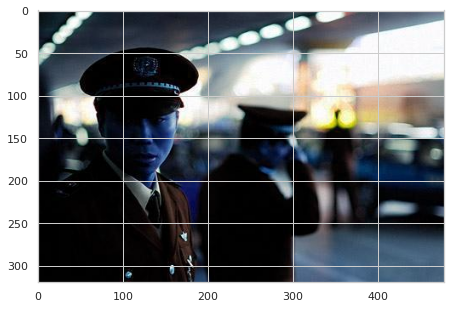

In [26]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')
plt.imshow(img)

In [27]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)

In [28]:
np.asarray(result).max()

1

/home/user/workspace/github/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

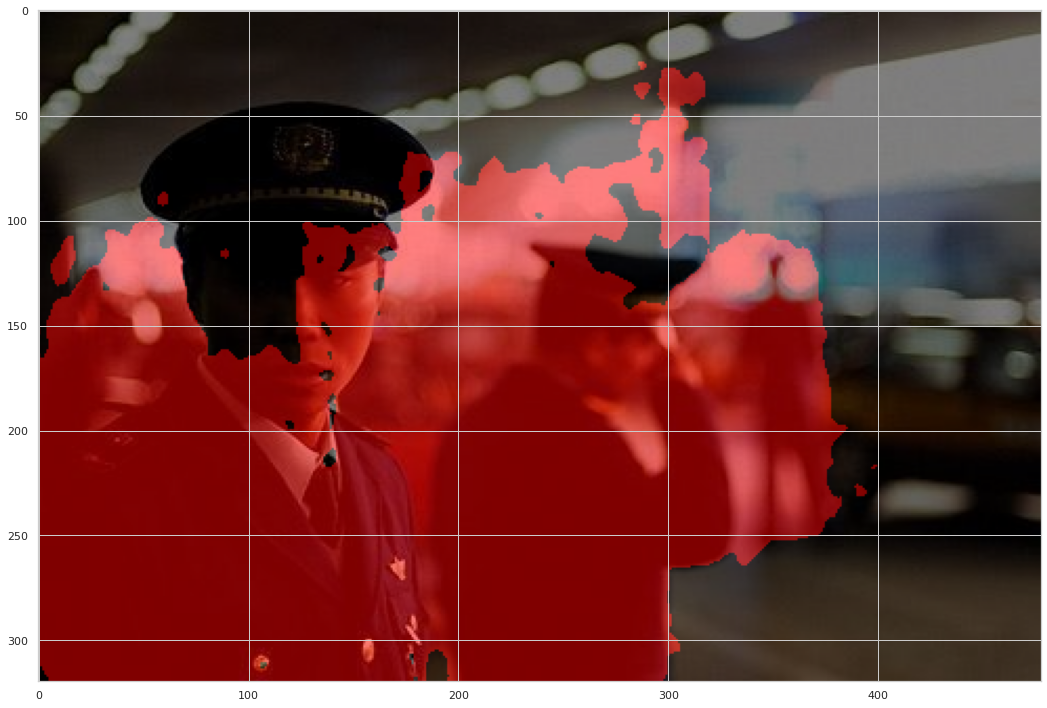

In [29]:
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

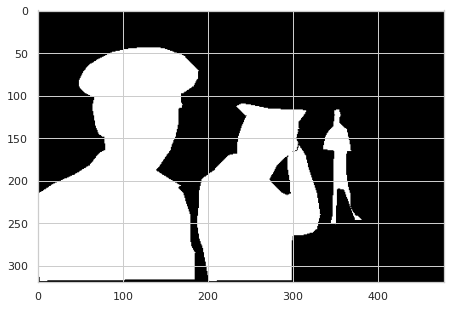

In [30]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/binary-labels/validation/ADE_val_00000011.png')
img[img == 1] = 255
plt.imshow(img, cmap="gray")

In [31]:
img.max()

255

In [32]:
img.min()

0

In [33]:
# print('show video')
# test a video and show the results
video = mmcv.VideoReader('../data/ramp.mp4')

In [34]:
import time

In [35]:
video[1].shape

(1080, 1920, 3)

In [36]:
x = 100

In [37]:
%%time
start = time.time()

for frame in video[:x]: # time - how many frame per sec - metrics acc - IoU
    result = inference_segmentor(model, frame)
    #model.show_result(frame, result)

end = time.time()

CPU times: user 9.4 s, sys: 336 ms, total: 9.74 s
Wall time: 7.87 s


In [38]:
from humanfriendly import format_timespan
aux0 = (end-start)
print("Time:", format_timespan(aux0))
aux1 = aux0/x
print("Time/frame:", format_timespan(aux1))
print("FPS: ", 1/aux1)

Time: 7.87 seconds
Time/frame: 0.08 seconds
FPS:  12.69876294130112


In [39]:
%%time

total_time = 0


for frame in video[:x]: # time - how many frame per sec - metrics acc - IoU
    start = time.time()
    result = inference_segmentor(model, frame)
    end = time.time()
    total_time += (end-start)
    #model.show_result(frame, result)

print(total_time)

7.49618935585022
CPU times: user 9.26 s, sys: 213 ms, total: 9.48 s
Wall time: 7.63 s


In [40]:
from humanfriendly import format_timespan
aux0 = total_time
print("Time:", format_timespan(aux0))
aux1 = aux0/x
print("Time/frame:", format_timespan(aux1))
print("FPS: ", 1/aux1)

Time: 7.5 seconds
Time/frame: 0.07 seconds
FPS:  13.340111255588472
